In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

#Reading data
data = pd.read_csv('price_data.csv', index_col="Date")
data.head()



Using TensorFlow backend.
/home/mlvm2/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Close,Volume,Market Cap,Oil,Gold,ETH,Ripple,Bitcoin Cash,Litecoin,NEO,Cardano,Stellar,EOS,DASH,NEM,ETH Classic,Lisk
Date,,,,,,,,,,,,,,,,,
"Aug 07, 2015",279.59,42484800,4.032820e+09,47.12,1080.05,2.770000,0.008152,0.008152,4.21,4.21,4.21,0.002432,0.002432,3.26,0.000145,0.000145,1.0
"Aug 08, 2015",261.00,58533000,4.048270e+09,47.12,1080.05,0.753325,0.008476,0.008476,3.85,3.85,3.85,0.002419,0.002419,3.08,0.000136,0.000136,1.0
"Aug 09, 2015",265.08,23789600,3.779770e+09,47.12,1080.05,0.701897,0.008808,0.008808,3.90,3.90,3.90,0.002345,0.002345,3.11,0.000130,0.000130,1.0
"Aug 10, 2015",264.47,20979400,3.843850e+09,44.96,1094.80,0.708448,0.008750,0.008750,3.95,3.95,3.95,0.002466,0.002466,3.08,0.000135,0.000135,1.0
"Aug 11, 2015",270.39,25433900,3.828500e+09,43.08,1113.25,1.070000,0.008591,0.008591,4.16,4.16,4.16,0.002398,0.002398,3.16,0.000135,0.000135,1.0


In [2]:
#Tranform the date field
data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22',
               '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26',
               '2018-01-27', '2018-01-28'],
              dtype='datetime64[ns]', name='Date', length=906, freq=None)


,Close,Volume,Market Cap,Oil,Gold,ETH,Ripple,Bitcoin Cash,Litecoin,NEO,Cardano,Stellar,EOS,DASH,NEM,ETH Classic,Lisk
Date,,,,,,,,,,,,,,,,,
2015-08-07,279.59,42484800,4.032820e+09,47.12,1080.05,2.770000,0.008152,0.008152,4.21,4.21,4.21,0.002432,0.002432,3.26,0.000145,0.000145,1.0
2015-08-08,261.00,58533000,4.048270e+09,47.12,1080.05,0.753325,0.008476,0.008476,3.85,3.85,3.85,0.002419,0.002419,3.08,0.000136,0.000136,1.0
2015-08-09,265.08,23789600,3.779770e+09,47.12,1080.05,0.701897,0.008808,0.008808,3.90,3.90,3.90,0.002345,0.002345,3.11,0.000130,0.000130,1.0
2015-08-10,264.47,20979400,3.843850e+09,44.96,1094.80,0.708448,0.008750,0.008750,3.95,3.95,3.95,0.002466,0.002466,3.08,0.000135,0.000135,1.0
2015-08-11,270.39,25433900,3.828500e+09,43.08,1113.25,1.070000,0.008591,0.008591,4.16,4.16,4.16,0.002398,0.002398,3.16,0.000135,0.000135,1.0


Text(0,0.5,'Daily Bitcoin price')

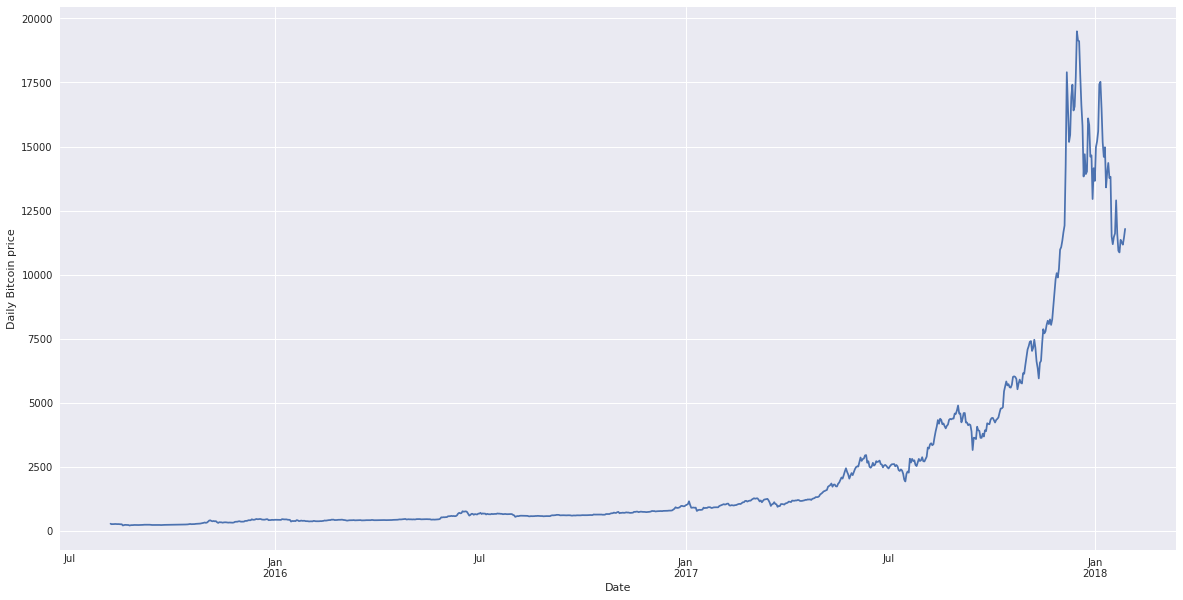

In [3]:

#Plotting the closed price
data['Close'].plot(figsize=(20,10))
plt.ylabel("Daily Bitcoin price")

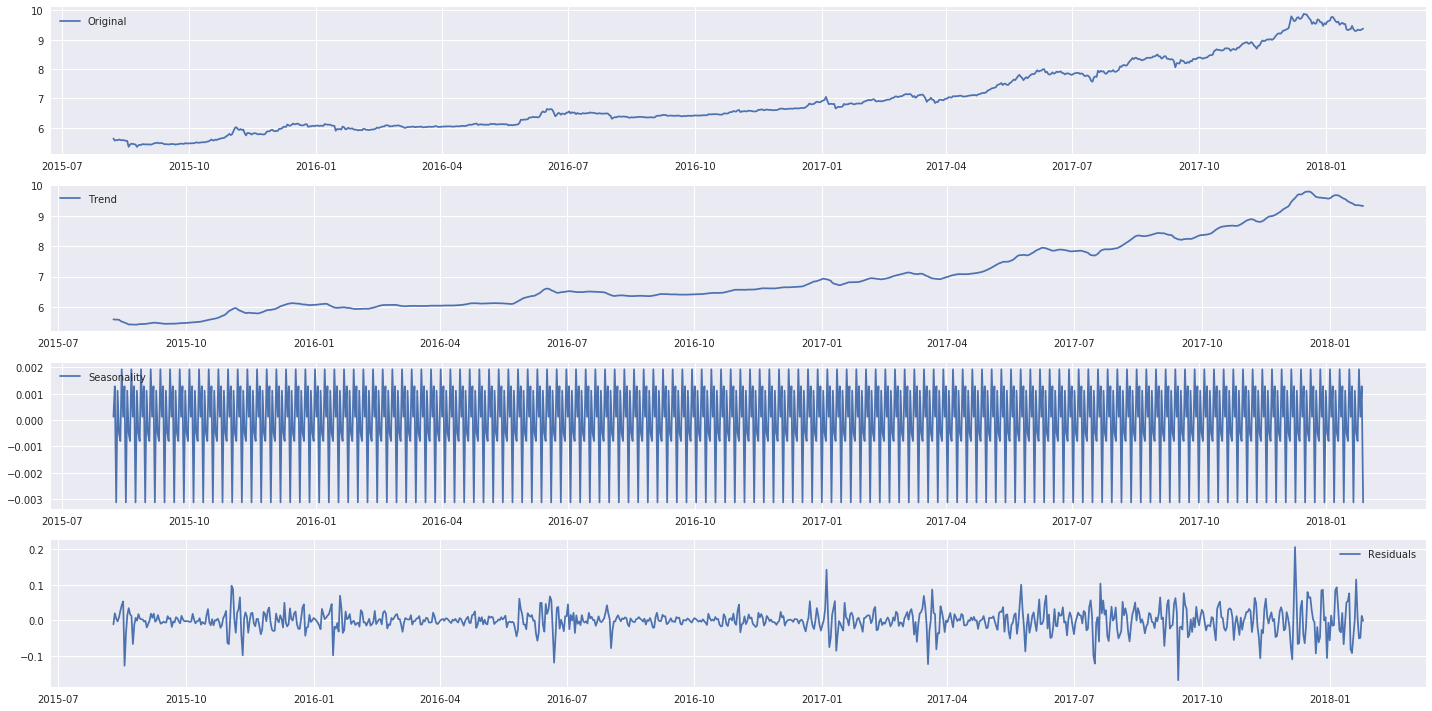

In [4]:
#Checking for seasonality
data1 = data['Close']  #Creating a dataframe with just the closed price 

#Plotting the trends (weekly, monthly, quaterly, yearly)
by_quarter = data1.groupby(data1.index.quarter)
by_quarter.plot(figsize=(20,10))

#Transform the data
ts_logtransformed = np.log(data1)
plt.plot(ts_logtransformed)

#Decomposing
decomposition = seasonal_decompose(ts_logtransformed)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [5]:
import statsmodels.tsa.stattools as ts

result = adfuller(ts_logtransformed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.983686
p-value: 0.994091
Critical Values:
	10%: -2.568
	5%: -2.865
	1%: -3.438


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
				#-----------------------------#
				#Using bitcoin historical data#
				#-----------------------------#

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 1s - loss: 0.0273 - val_loss: 0.1204
Epoch 2/50
 - 0s - loss: 0.0538 - val_loss: 0.0795
Epoch 3/50
 - 0s - loss: 0.0324 - val_loss: 0.1177
Epoch 4/50
 - 0s - loss: 0.0178 - val_loss: 0.1067
Epoch 5/50
 - 1s - loss: 0.0151 - val_loss: 0.0968
Epoch 6/50
 - 0s - loss: 0.0121 - val_loss: 0.0866
Epoch 7/50
 - 0s - loss: 0.0118 - val_loss: 0.0815
Epoch 8/50
 - 0s - loss: 0.0101 - val_loss: 0.0769
Epoch 9/50
 - 0s - loss: 0.0083 - val_loss: 0.0633
Epoch 10/50
 - 0s - loss: 0.0073 - val_loss: 0.0560
Epoch 11/50
 - 0s - loss: 0.0069 - val_loss: 0.0562
Epoch 12/50
 - 0s - loss: 0.0063 - val_loss: 0.0509
Epoch 13/50
 - 0s - loss: 0.0054 -

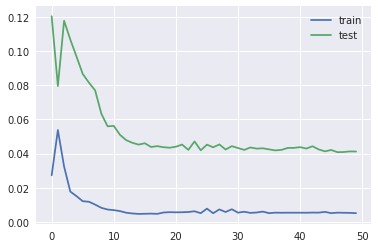

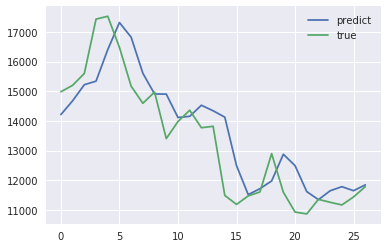

Test RMSE: 1035.896


In [8]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
X = 
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 1s - loss: 0.0418 - val_loss: 0.3469
Epoch 2/50
 - 0s - loss: 0.0821 - val_loss: 0.3060
Epoch 3/50
 - 0s - loss: 0.0333 - val_loss: 0.1325
Epoch 4/50
 - 0s - loss: 0.0440 - val_loss: 0.0522
Epoch 5/50
 - 0s - loss: 0.0158 - val_loss: 0.1039
Epoch 6/50
 - 0s - loss: 0.0155 - val_loss: 0.0928
Epoch 7/50
 - 0s - loss: 0.0131 - val_loss: 0.0932
Epoch 8/50
 - 0s - loss: 0.0108 - val_loss: 0.1026
Epoch 9/50
 - 0s - loss: 0.0102 - val_loss: 0.0984
Epoch 10/50
 - 0s - loss: 0.0087 - val_loss: 0.0908
Epoch 11/50
 - 0s - loss: 0.0090 - val_loss: 0.0835
Epoch 12/50
 - 0s - loss: 0.0089 - val_loss: 0.0789
Epoch 13/50
 - 0s - loss: 0.0077 -

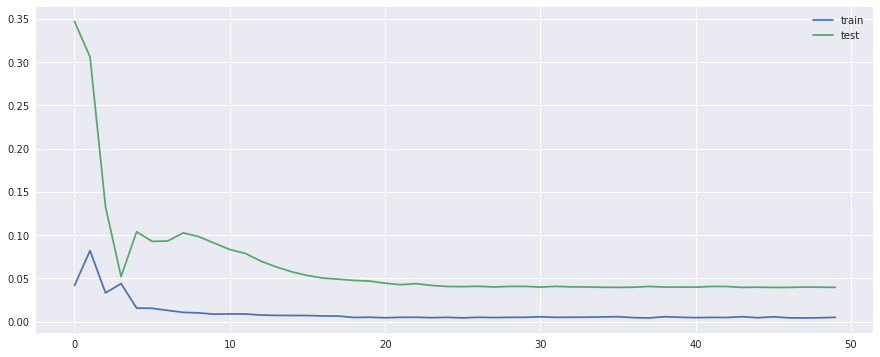

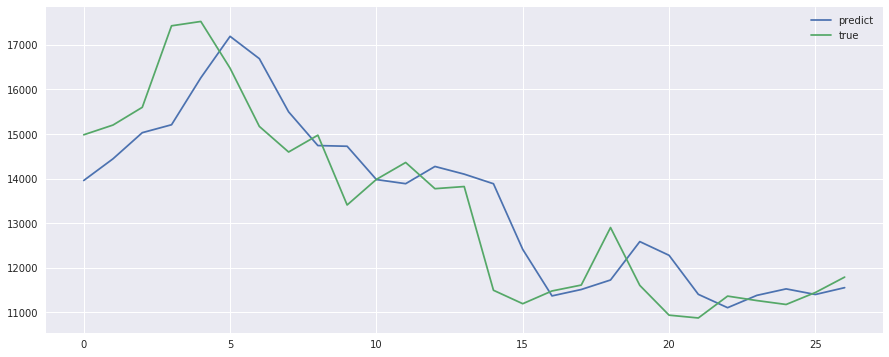

Test RMSE: 989.122


In [18]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 1s - loss: 0.0576 - val_loss: 0.5050
Epoch 2/50
 - 0s - loss: 0.0829 - val_loss: 0.4554
Epoch 3/50
 - 0s - loss: 0.0611 - val_loss: 0.3781
Epoch 4/50
 - 0s - loss: 0.0490 - val_loss: 0.2743
Epoch 5/50
 - 0s - loss: 0.0389 - val_loss: 0.1558
Epoch 6/50
 - 0s - loss: 0.0266 - val_loss: 0.0514
Epoch 7/50
 - 0s - loss: 0.0189 - val_loss: 0.0999
Epoch 8/50
 - 0s - loss: 0.0122 - val_loss: 0.1047
Epoch 9/50
 - 0s - loss: 0.0150 - val_loss: 0.0906
Epoch 10/50
 - 0s - loss: 0.0170 - val_loss: 0.0883
Epoch 11/50
 - 0s - loss: 0.0112 - val_loss: 0.0855
Epoch 12/50
 - 0s - loss: 0.0121 - val_loss: 0.0731
Epoch 13/50
 - 0s - loss: 0.0151 -

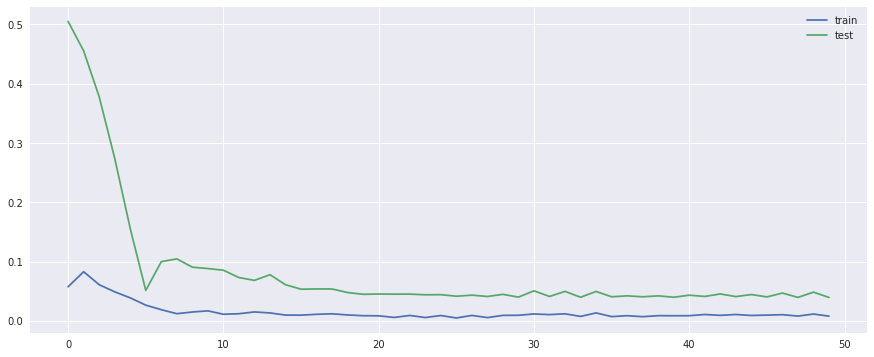

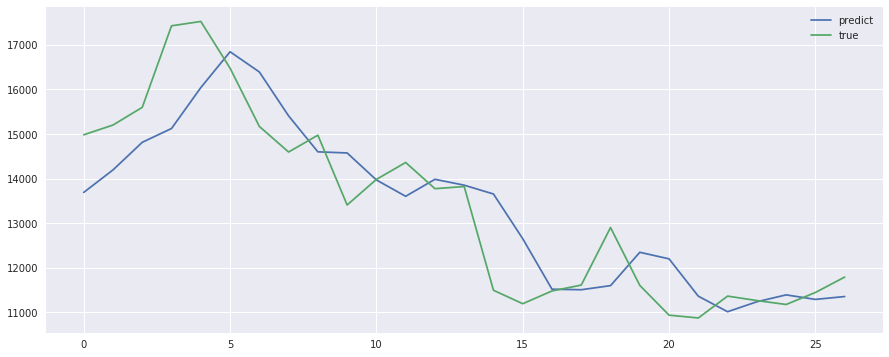

Test RMSE: 991.455


In [19]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 1s - loss: 0.0600 - val_loss: 0.5205
Epoch 2/50
 - 0s - loss: 0.0770 - val_loss: 0.4838
Epoch 3/50
 - 0s - loss: 0.0675 - val_loss: 0.4520
Epoch 4/50
 - 0s - loss: 0.0585 - val_loss: 0.4030
Epoch 5/50
 - 0s - loss: 0.0520 - val_loss: 0.3446
Epoch 6/50
 - 0s - loss: 0.0458 - val_loss: 0.2792
Epoch 7/50
 - 0s - loss: 0.0395 - val_loss: 0.2075
Epoch 8/50
 - 0s - loss: 0.0316 - val_loss: 0.1259
Epoch 9/50
 - 0s - loss: 0.0237 - val_loss: 0.0581
Epoch 10/50
 - 0s - loss: 0.0170 - val_loss: 0.0698
Epoch 11/50
 - 0s - loss: 0.0131 - val_loss: 0.1158
Epoch 12/50
 - 0s - loss: 0.0125 - val_loss: 0.1355
Epoch 13/50
 - 0s - loss: 0.0105 -

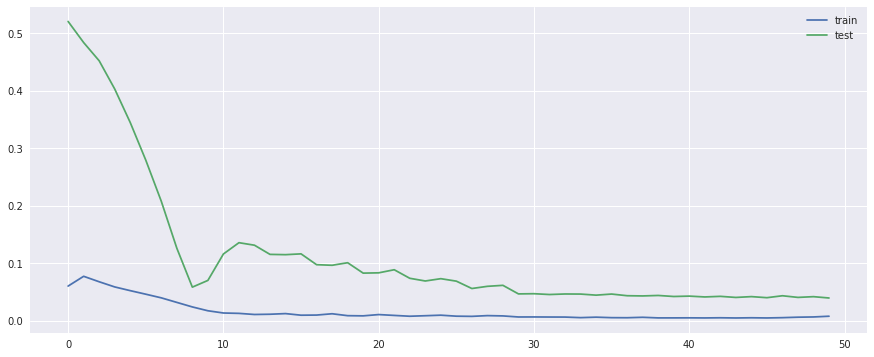

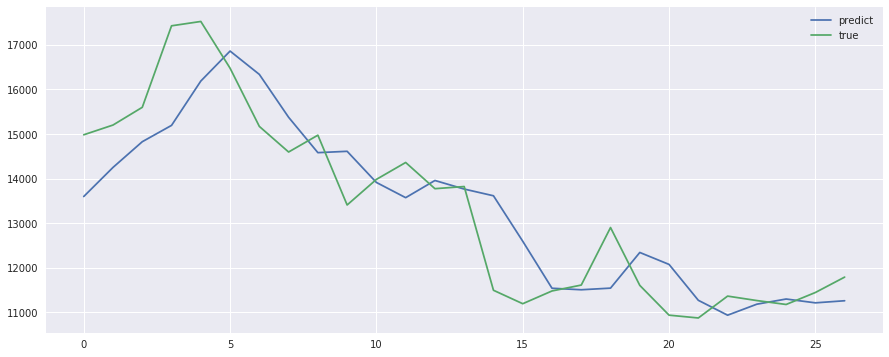

Test RMSE: 971.603


In [20]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(878, 1, 3) (878,) (27, 1, 3) (27,)
Train on 878 samples, validate on 27 samples
Epoch 1/50
 - 1s - loss: 0.0647 - val_loss: 0.5427
Epoch 2/50
 - 0s - loss: 0.0747 - val_loss: 0.4933
Epoch 3/50
 - 0s - loss: 0.0678 - val_loss: 0.4544
Epoch 4/50
 - 0s - loss: 0.0589 - val_loss: 0.4037
Epoch 5/50
 - 0s - loss: 0.0519 - val_loss: 0.3445
Epoch 6/50
 - 0s - loss: 0.0458 - val_loss: 0.2814
Epoch 7/50
 - 0s - loss: 0.0396 - val_loss: 0.2151
Epoch 8/50
 - 0s - loss: 0.0325 - val_loss: 0.1427
Epoch 9/50
 - 0s - loss: 0.0250 - val_loss: 0.0749
Epoch 10/50
 - 0s - loss: 0.0187 - val_loss: 0.0532
Epoch 11/50
 - 0s - loss: 0.0149 - val_loss: 0.0827
Epoch 12/50
 - 0s - loss: 0.0109 - val_loss: 0.1084
Epoch 13/50
 - 0s - loss: 0.0142 -

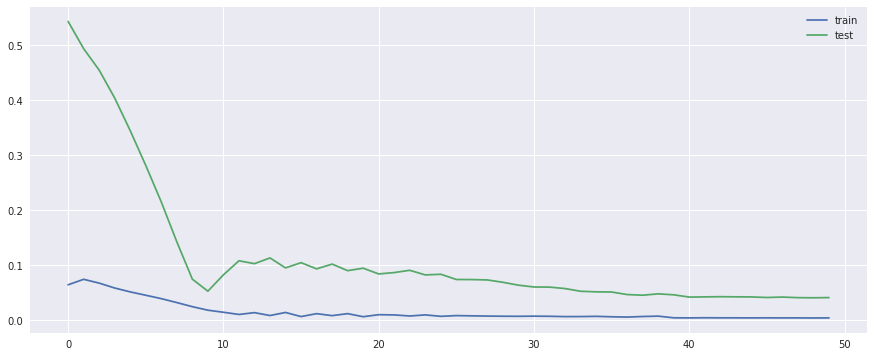

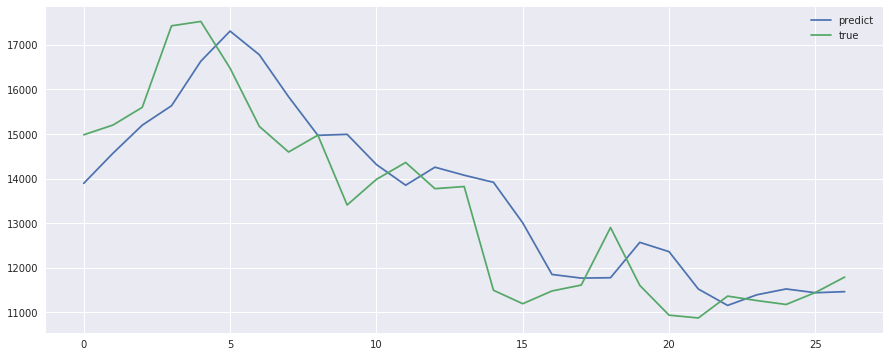

Test RMSE: 1019.393


In [21]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train = 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 1s - loss: 0.0048 - val_loss: 0.2278
Epoch 2/50
 - 0s - loss: 0.0182 - val_loss: 0.2329
Epoch 3/50
 - 0s - loss: 0.0133 - val_loss: 0.2293
Epoch 4/50
 - 0s - loss: 0.0101 - val_loss: 0.2081
Epoch 5/50
 - 0s - loss: 0.0094 - val_loss: 0.1869
Epoch 6/50
 - 0s - loss: 0.0102 - val_loss: 0.1735
Epoch 7/50
 - 0s - loss: 0.0092 - val_loss: 0.1557
Epoch 8/50
 - 0s - loss: 0.0087 - val_loss: 0.1370
Epoch 9/50
 - 0s - loss: 0.0081 - val_loss: 0.1161
Epoch 10/50
 - 0s - loss: 0.0084 - val_loss: 0.1006
Epoch 11/50
 - 0s - loss: 0.0069 - val_loss: 0.0763
Epoch 12/50
 - 0s - loss: 0.0062 - val_loss: 0.0538
Epoch 13/50
 - 0s - loss: 0.006

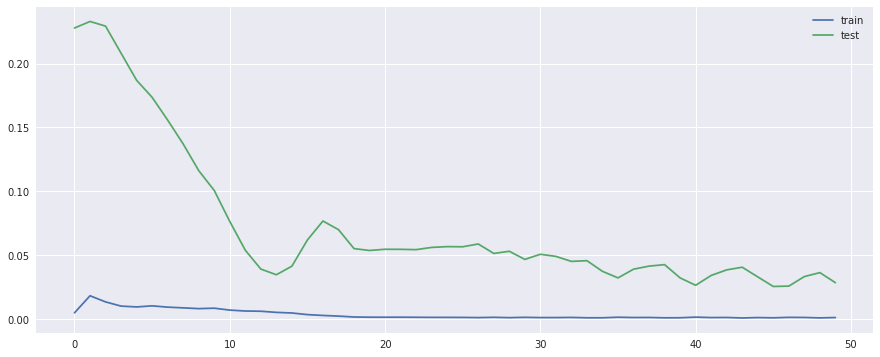

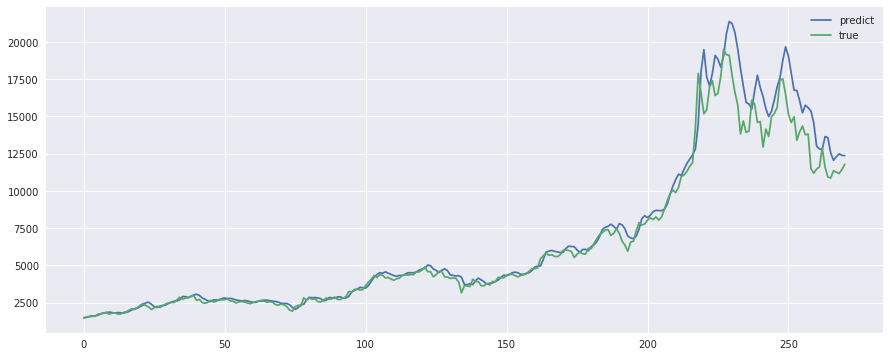

Test RMSE: 1050.708


In [14]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 1s - loss: 0.0038 - val_loss: 0.2202
Epoch 2/50
 - 0s - loss: 0.0255 - val_loss: 0.2381
Epoch 3/50
 - 0s - loss: 0.0085 - val_loss: 0.1835
Epoch 4/50
 - 0s - loss: 0.0212 - val_loss: 0.1950
Epoch 5/50
 - 0s - loss: 0.0066 - val_loss: 0.1384
Epoch 6/50
 - 0s - loss: 0.0198 - val_loss: 0.1531
Epoch 7/50
 - 0s - loss: 0.0047 - val_loss: 0.0976
Epoch 8/50
 - 0s - loss: 0.0144 - val_loss: 0.1028
Epoch 9/50
 - 0s - loss: 0.0094 - val_loss: 0.0620
Epoch 10/50
 - 0s - loss: 0.0108 - val_loss: 0.0408
Epoch 11/50
 - 0s - loss: 0.0083 - val_loss: 0.0320
Epoch 12/50
 - 0s - loss: 0.0059 - val_loss: 0.0316
Epoch 13/50
 - 0s - loss: 0.004

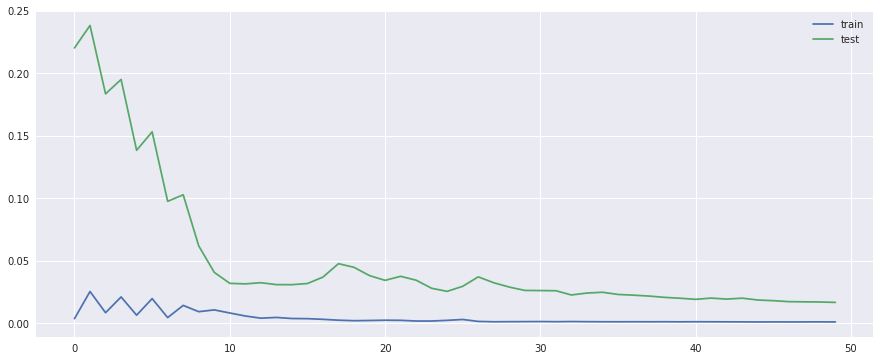

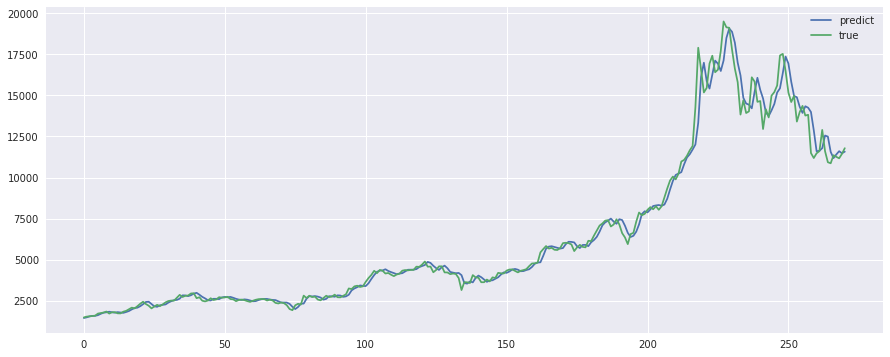

Test RMSE: 617.872


In [22]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 1s - loss: 0.0048 - val_loss: 0.2412
Epoch 2/50
 - 0s - loss: 0.0236 - val_loss: 0.2504
Epoch 3/50
 - 0s - loss: 0.0140 - val_loss: 0.2339
Epoch 4/50
 - 0s - loss: 0.0111 - val_loss: 0.2045
Epoch 5/50
 - 0s - loss: 0.0146 - val_loss: 0.1987
Epoch 6/50
 - 0s - loss: 0.0113 - val_loss: 0.1758
Epoch 7/50
 - 0s - loss: 0.0097 - val_loss: 0.1462
Epoch 8/50
 - 0s - loss: 0.0125 - val_loss: 0.1368
Epoch 9/50
 - 0s - loss: 0.0090 - val_loss: 0.1070
Epoch 10/50
 - 0s - loss: 0.0087 - val_loss: 0.0784
Epoch 11/50
 - 0s - loss: 0.0084 - val_loss: 0.0536
Epoch 12/50
 - 0s - loss: 0.0080 - val_loss: 0.0390
Epoch 13/50
 - 0s - loss: 0.006

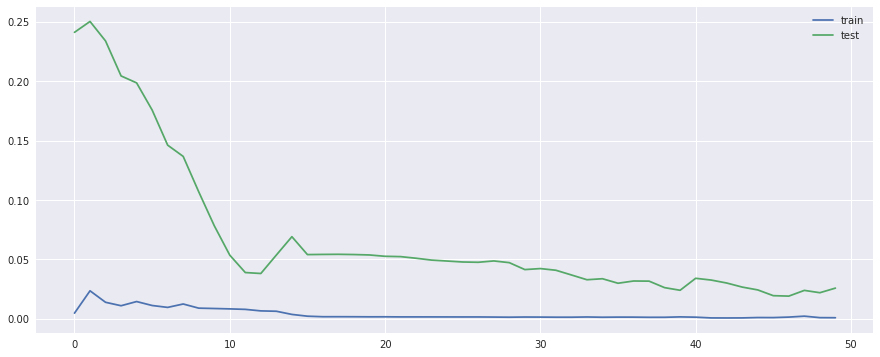

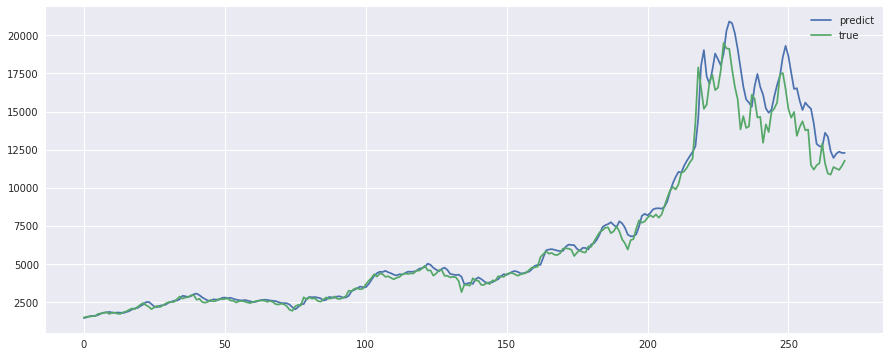

Test RMSE: 948.131


In [23]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 1s - loss: 0.0052 - val_loss: 0.2523
Epoch 2/50
 - 0s - loss: 0.0200 - val_loss: 0.2554
Epoch 3/50
 - 0s - loss: 0.0144 - val_loss: 0.2532
Epoch 4/50
 - 0s - loss: 0.0114 - val_loss: 0.2350
Epoch 5/50
 - 0s - loss: 0.0103 - val_loss: 0.2144
Epoch 6/50
 - 0s - loss: 0.0109 - val_loss: 0.2007
Epoch 7/50
 - 0s - loss: 0.0103 - val_loss: 0.1854
Epoch 8/50
 - 0s - loss: 0.0095 - val_loss: 0.1676
Epoch 9/50
 - 0s - loss: 0.0096 - val_loss: 0.1529
Epoch 10/50
 - 0s - loss: 0.0087 - val_loss: 0.1336
Epoch 11/50
 - 0s - loss: 0.0080 - val_loss: 0.1123
Epoch 12/50
 - 0s - loss: 0.0079 - val_loss: 0.0925
Epoch 13/50
 - 0s - loss: 0.006

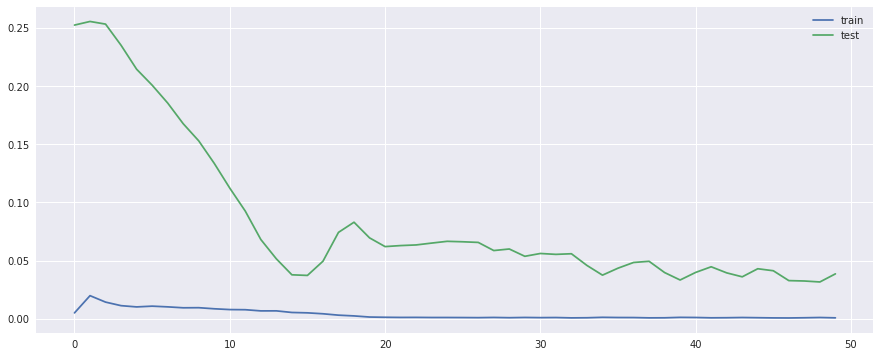

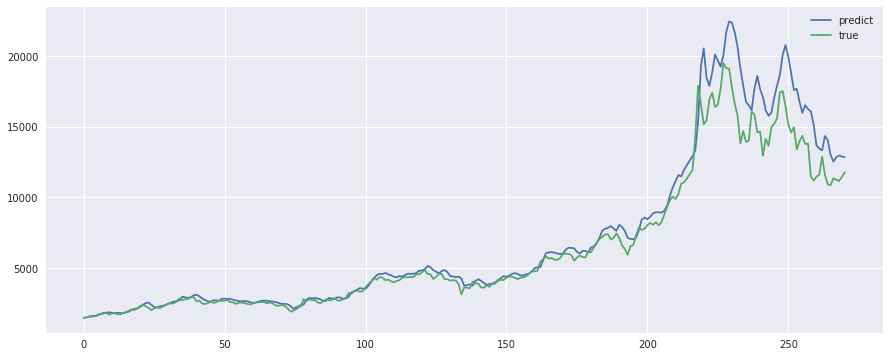

Test RMSE: 1373.487


In [24]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(634, 1, 3) (634,) (271, 1, 3) (271,)
Train on 634 samples, validate on 271 samples
Epoch 1/50
 - 1s - loss: 0.0060 - val_loss: 0.2654
Epoch 2/50
 - 0s - loss: 0.0194 - val_loss: 0.2611
Epoch 3/50
 - 0s - loss: 0.0149 - val_loss: 0.2670
Epoch 4/50
 - 0s - loss: 0.0125 - val_loss: 0.2590
Epoch 5/50
 - 0s - loss: 0.0110 - val_loss: 0.2450
Epoch 6/50
 - 0s - loss: 0.0105 - val_loss: 0.2305
Epoch 7/50
 - 0s - loss: 0.0108 - val_loss: 0.2199
Epoch 8/50
 - 0s - loss: 0.0105 - val_loss: 0.2097
Epoch 9/50
 - 0s - loss: 0.0099 - val_loss: 0.1970
Epoch 10/50
 - 0s - loss: 0.0097 - val_loss: 0.1851
Epoch 11/50
 - 0s - loss: 0.0092 - val_loss: 0.1719
Epoch 12/50
 - 0s - loss: 0.0089 - val_loss: 0.1589
Epoch 13/50
 - 0s - loss: 0.008

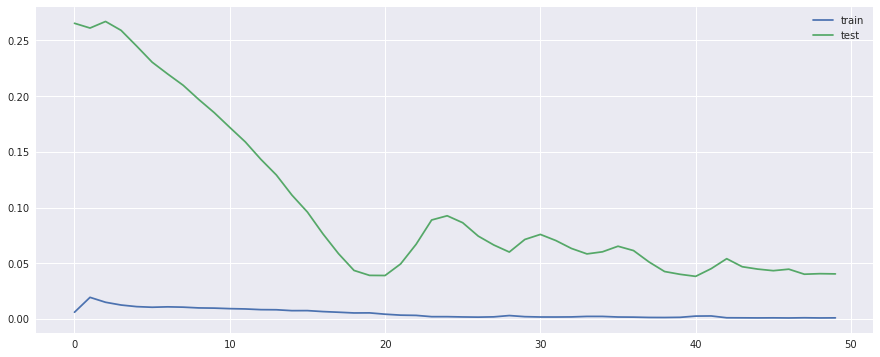

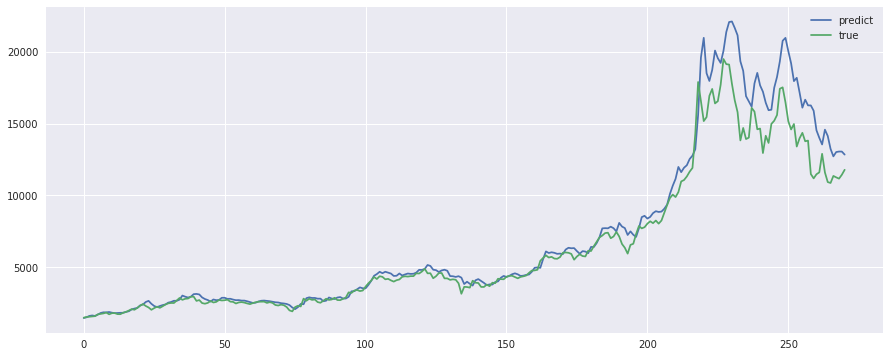

Test RMSE: 1454.610


In [25]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0129 - val_loss: 0.3249
Epoch 2/50
 - 0s - loss: 0.0300 - val_loss: 0.3133
Epoch 3/50
 - 0s - loss: 0.0223 - val_loss: 0.3001
Epoch 4/50
 - 0s - loss: 0.0167 - val_loss: 0.2614
Epoch 5/50
 - 0s - loss: 0.0195 - val_loss: 0.2386
Epoch 6/50
 - 0s - loss: 0.0145 - val_loss: 0.1987
Epoch 7/50
 - 0s - loss: 0.0170 - val_loss: 0.1735
Epoch 8/50
 - 0s - loss: 0.0113 - val_loss: 0.1247
Epoch 9/50
 - 0s - loss: 0.0140 - val_loss: 0.0936
Epoch 10/50
 - 0s - loss: 0.0073 - val_loss: 0.0477
Epoch 11/50
 - 0s - loss: 0.0113 - val_loss: 0.0471
Epoch 12/50
 - 0s - loss: 0.0019 - val_loss: 0.0585
Epoch 13/50
 - 0s - loss: 0.004

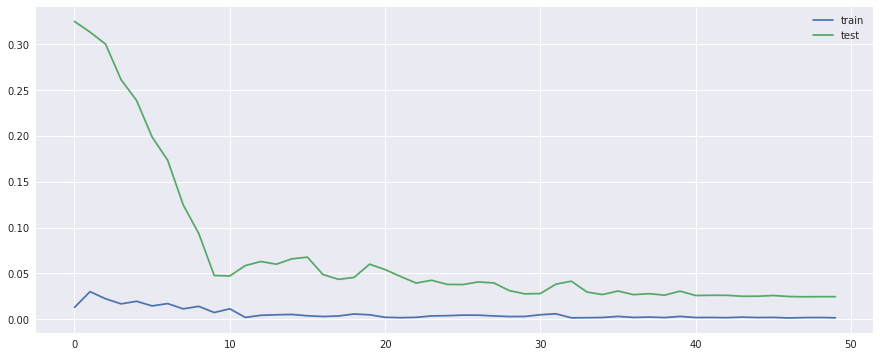

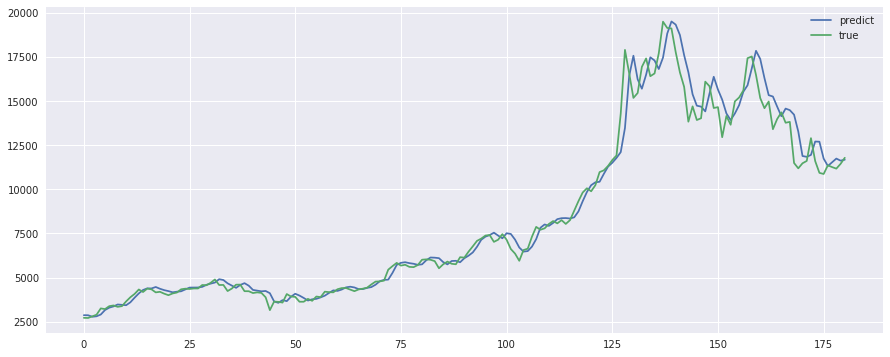

Test RMSE: 806.374


In [26]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0095 - val_loss: 0.2747
Epoch 2/50
 - 0s - loss: 0.0415 - val_loss: 0.2828
Epoch 3/50
 - 0s - loss: 0.0187 - val_loss: 0.2186
Epoch 4/50
 - 0s - loss: 0.0267 - val_loss: 0.1965
Epoch 5/50
 - 0s - loss: 0.0133 - val_loss: 0.1110
Epoch 6/50
 - 0s - loss: 0.0234 - val_loss: 0.0831
Epoch 7/50
 - 0s - loss: 0.0090 - val_loss: 0.0484
Epoch 8/50
 - 0s - loss: 0.0117 - val_loss: 0.0561
Epoch 9/50
 - 0s - loss: 0.0090 - val_loss: 0.0563
Epoch 10/50
 - 0s - loss: 0.0048 - val_loss: 0.0526
Epoch 11/50
 - 0s - loss: 0.0065 - val_loss: 0.0586
Epoch 12/50
 - 0s - loss: 0.0031 - val_loss: 0.0582
Epoch 13/50
 - 0s - loss: 0.003

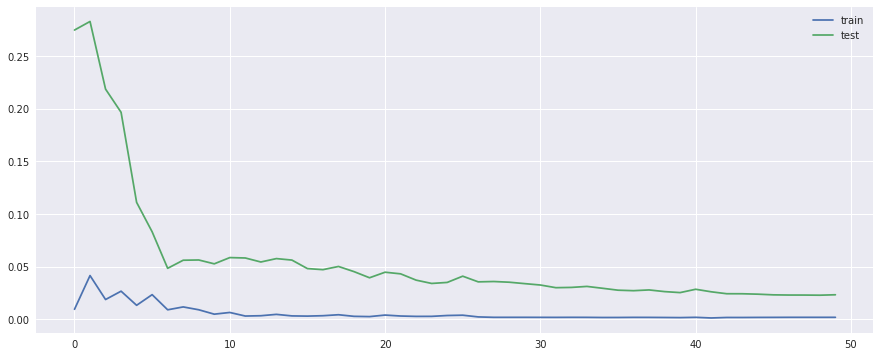

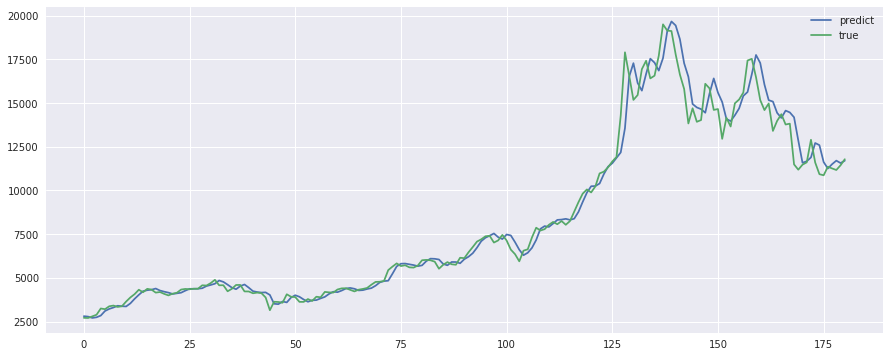

Test RMSE: 771.549


In [27]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0122 - val_loss: 0.3177
Epoch 2/50
 - 0s - loss: 0.0331 - val_loss: 0.3094
Epoch 3/50
 - 0s - loss: 0.0197 - val_loss: 0.2746
Epoch 4/50
 - 0s - loss: 0.0224 - val_loss: 0.2538
Epoch 5/50
 - 0s - loss: 0.0151 - val_loss: 0.2040
Epoch 6/50
 - 0s - loss: 0.0200 - val_loss: 0.1797
Epoch 7/50
 - 0s - loss: 0.0116 - val_loss: 0.1197
Epoch 8/50
 - 0s - loss: 0.0175 - val_loss: 0.0919
Epoch 9/50
 - 0s - loss: 0.0064 - val_loss: 0.0409
Epoch 10/50
 - 0s - loss: 0.0150 - val_loss: 0.0504
Epoch 11/50
 - 0s - loss: 0.0023 - val_loss: 0.0686
Epoch 12/50
 - 0s - loss: 0.0025 - val_loss: 0.0628
Epoch 13/50
 - 0s - loss: 0.002

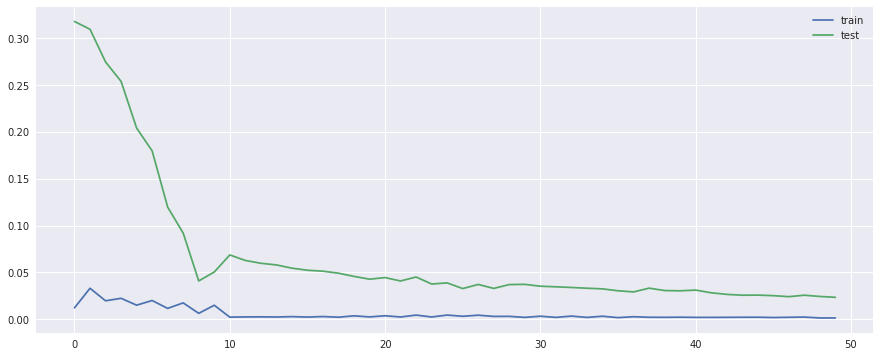

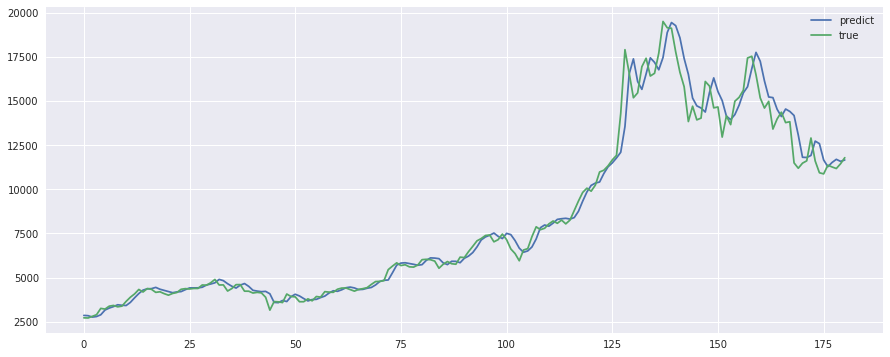

Test RMSE: 775.119


In [28]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0125 - val_loss: 0.3179
Epoch 2/50
 - 0s - loss: 0.0310 - val_loss: 0.3064
Epoch 3/50
 - 0s - loss: 0.0236 - val_loss: 0.3001
Epoch 4/50
 - 0s - loss: 0.0176 - val_loss: 0.2642
Epoch 5/50
 - 0s - loss: 0.0186 - val_loss: 0.2396
Epoch 6/50
 - 0s - loss: 0.0154 - val_loss: 0.2063
Epoch 7/50
 - 0s - loss: 0.0163 - val_loss: 0.1805
Epoch 8/50
 - 0s - loss: 0.0118 - val_loss: 0.1354
Epoch 9/50
 - 0s - loss: 0.0149 - val_loss: 0.1085
Epoch 10/50
 - 0s - loss: 0.0089 - val_loss: 0.0644
Epoch 11/50
 - 0s - loss: 0.0116 - val_loss: 0.0533
Epoch 12/50
 - 0s - loss: 0.0044 - val_loss: 0.0566
Epoch 13/50
 - 0s - loss: 0.009

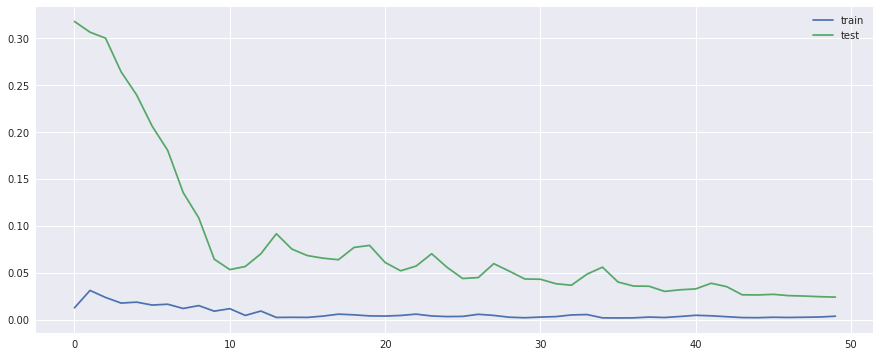

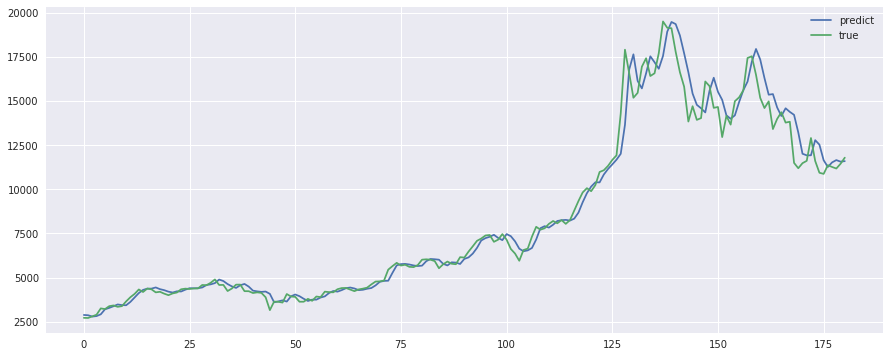

Test RMSE: 794.675


In [29]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(724, 1, 3) (724,) (181, 1, 3) (181,)
Train on 724 samples, validate on 181 samples
Epoch 1/50
 - 1s - loss: 0.0145 - val_loss: 0.3451
Epoch 2/50
 - 0s - loss: 0.0289 - val_loss: 0.3315
Epoch 3/50
 - 0s - loss: 0.0253 - val_loss: 0.3314
Epoch 4/50
 - 0s - loss: 0.0201 - val_loss: 0.3143
Epoch 5/50
 - 0s - loss: 0.0192 - val_loss: 0.2968
Epoch 6/50
 - 0s - loss: 0.0180 - val_loss: 0.2766
Epoch 7/50
 - 0s - loss: 0.0180 - val_loss: 0.2601
Epoch 8/50
 - 0s - loss: 0.0160 - val_loss: 0.2361
Epoch 9/50
 - 0s - loss: 0.0163 - val_loss: 0.2170
Epoch 10/50
 - 0s - loss: 0.0139 - val_loss: 0.1884
Epoch 11/50
 - 0s - loss: 0.0146 - val_loss: 0.1659
Epoch 12/50
 - 0s - loss: 0.0118 - val_loss: 0.1327
Epoch 13/50
 - 0s - loss: 0.012

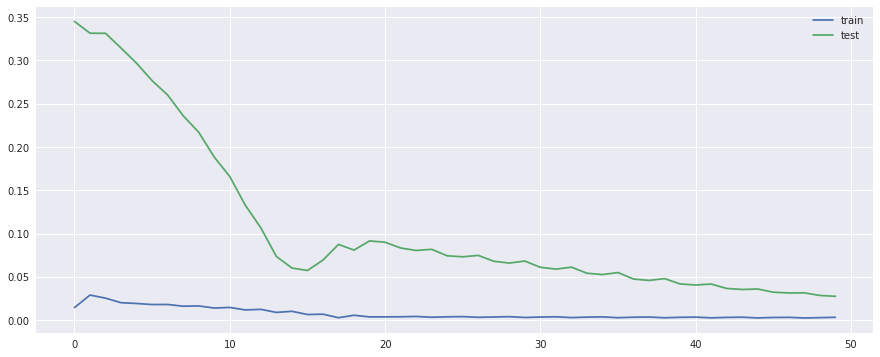

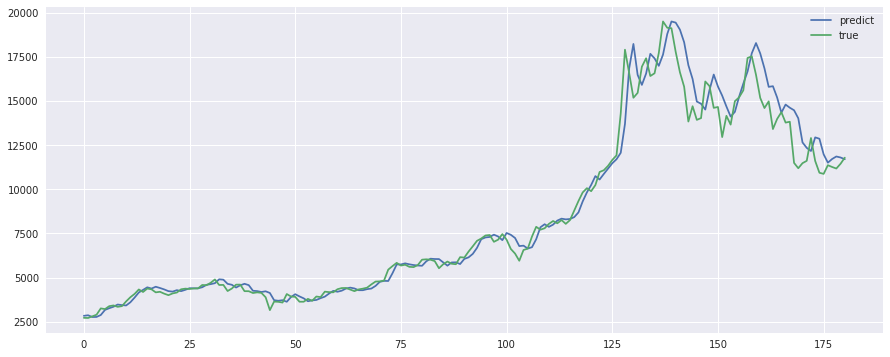

Test RMSE: 900.733


In [30]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 2s - loss: 0.0037 - val_loss: 0.1531
Epoch 2/50
 - 0s - loss: 0.0057 - val_loss: 0.1458
Epoch 3/50
 - 0s - loss: 0.0049 - val_loss: 0.1378
Epoch 4/50
 - 0s - loss: 0.0053 - val_loss: 0.1343
Epoch 5/50
 - 0s - loss: 0.0045 - val_loss: 0.1268
Epoch 6/50
 - 0s - loss: 0.0049 - val_loss: 0.1214
Epoch 7/50
 - 0s - loss: 0.0047 - val_loss: 0.1154
Epoch 8/50
 - 0s - loss: 0.0044 - val_loss: 0.1081
Epoch 9/50
 - 0s - loss: 0.0044 - val_loss: 0.1013
Epoch 10/50
 - 0s - loss: 0.0042 - val_loss: 0.0939
Epoch 11/50
 - 0s - loss: 0.0041 - val_loss: 0.0852
Epoch 12/50
 - 0s - loss: 0.0039 - val_loss: 0.0786
Epoch 13/50
 - 0s - loss: 0.003

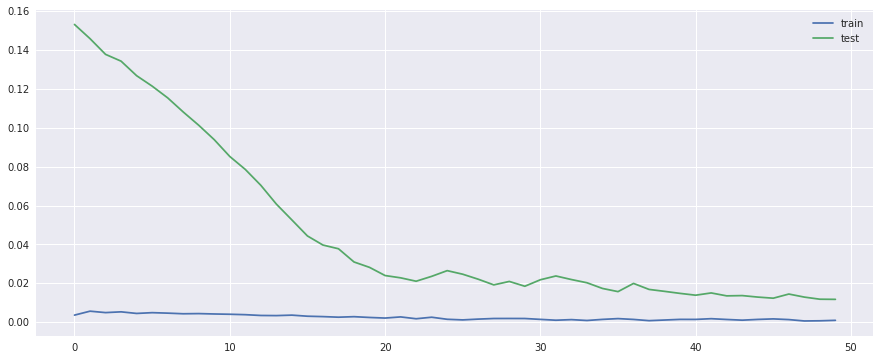

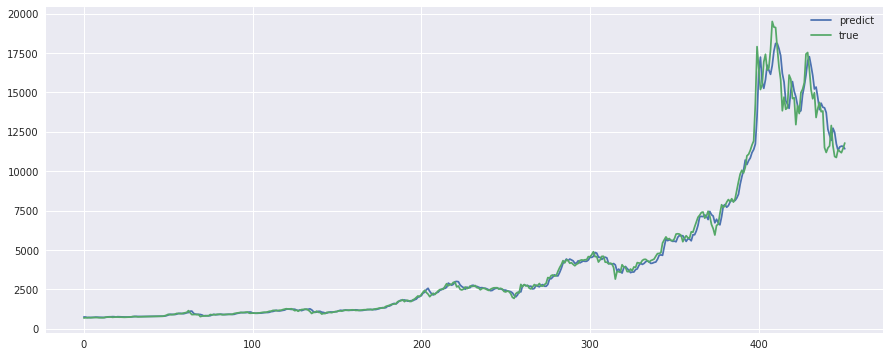

Test RMSE: 512.040


In [32]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 2s - loss: 0.0032 - val_loss: 0.1695
Epoch 2/50
 - 0s - loss: 0.0123 - val_loss: 0.1768
Epoch 3/50
 - 0s - loss: 0.0047 - val_loss: 0.1536
Epoch 4/50
 - 0s - loss: 0.0125 - val_loss: 0.1595
Epoch 5/50
 - 0s - loss: 0.0046 - val_loss: 0.1398
Epoch 6/50
 - 0s - loss: 0.0115 - val_loss: 0.1456
Epoch 7/50
 - 0s - loss: 0.0044 - val_loss: 0.1266
Epoch 8/50
 - 0s - loss: 0.0109 - val_loss: 0.1326
Epoch 9/50
 - 0s - loss: 0.0039 - val_loss: 0.1130
Epoch 10/50
 - 0s - loss: 0.0104 - val_loss: 0.1224
Epoch 11/50
 - 0s - loss: 0.0026 - val_loss: 0.1038
Epoch 12/50
 - 0s - loss: 0.0072 - val_loss: 0.1052
Epoch 13/50
 - 0s - loss: 0.006

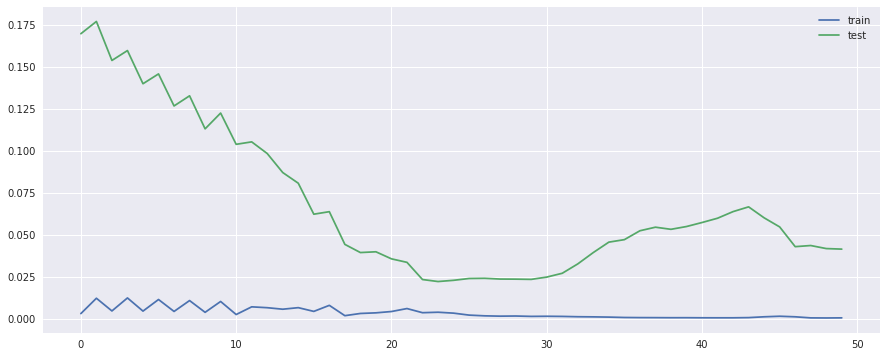

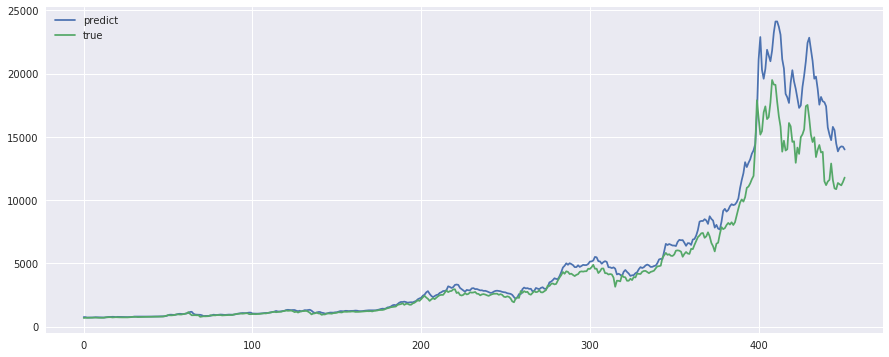

Test RMSE: 1683.565


In [33]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 2s - loss: 0.0027 - val_loss: 0.1640
Epoch 2/50
 - 0s - loss: 0.0115 - val_loss: 0.1727
Epoch 3/50
 - 0s - loss: 0.0049 - val_loss: 0.1541
Epoch 4/50
 - 0s - loss: 0.0098 - val_loss: 0.1507
Epoch 5/50
 - 0s - loss: 0.0081 - val_loss: 0.1511
Epoch 6/50
 - 0s - loss: 0.0044 - val_loss: 0.1333
Epoch 7/50
 - 0s - loss: 0.0088 - val_loss: 0.1309
Epoch 8/50
 - 0s - loss: 0.0070 - val_loss: 0.1289
Epoch 9/50
 - 0s - loss: 0.0045 - val_loss: 0.1137
Epoch 10/50
 - 0s - loss: 0.0076 - val_loss: 0.1118
Epoch 11/50
 - 0s - loss: 0.0045 - val_loss: 0.0979
Epoch 12/50
 - 0s - loss: 0.0073 - val_loss: 0.0958
Epoch 13/50
 - 0s - loss: 0.004

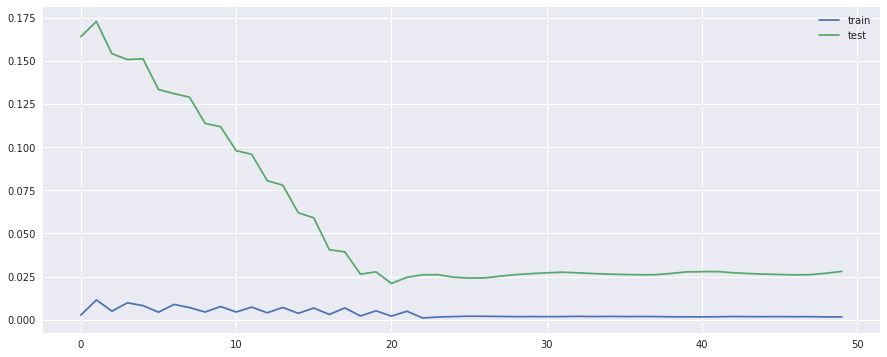

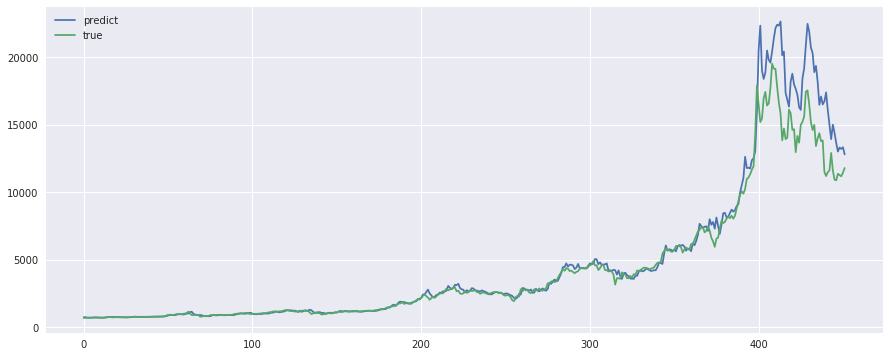

Test RMSE: 1344.592


In [34]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 2s - loss: 0.0029 - val_loss: 0.1768
Epoch 2/50
 - 0s - loss: 0.0120 - val_loss: 0.1818
Epoch 3/50
 - 0s - loss: 0.0090 - val_loss: 0.1887
Epoch 4/50
 - 0s - loss: 0.0055 - val_loss: 0.1751
Epoch 5/50
 - 0s - loss: 0.0078 - val_loss: 0.1700
Epoch 6/50
 - 0s - loss: 0.0080 - val_loss: 0.1723
Epoch 7/50
 - 0s - loss: 0.0053 - val_loss: 0.1620
Epoch 8/50
 - 0s - loss: 0.0072 - val_loss: 0.1578
Epoch 9/50
 - 0s - loss: 0.0070 - val_loss: 0.1580
Epoch 10/50
 - 0s - loss: 0.0048 - val_loss: 0.1475
Epoch 11/50
 - 0s - loss: 0.0068 - val_loss: 0.1436
Epoch 12/50
 - 0s - loss: 0.0065 - val_loss: 0.1431
Epoch 13/50
 - 0s - loss: 0.004

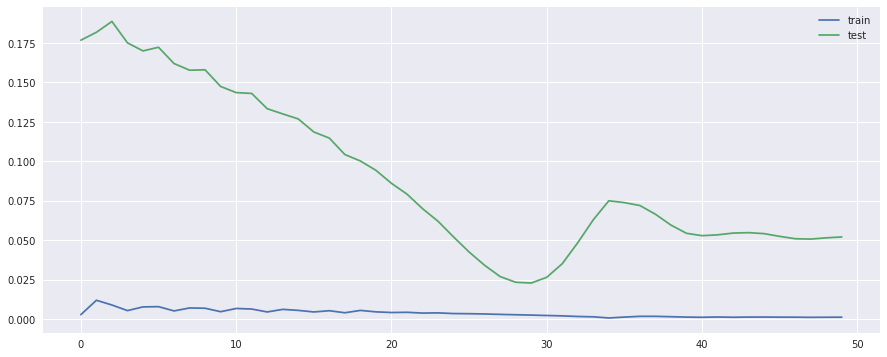

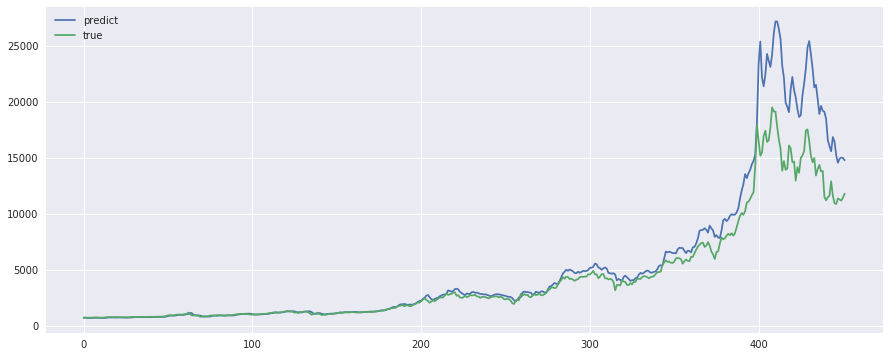

Test RMSE: 2272.493


In [35]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.003582   0.001249   0.003033  0.002618
2   0.002618   0.001923   0.003081  0.002830
3   0.002830   0.000465   0.002250  0.002798
4   0.002798   0.000347   0.002448  0.003105
5   0.003105   0.000534   0.002401  0.002897
(453, 1, 3) (453,) (452, 1, 3) (452,)
Train on 453 samples, validate on 452 samples
Epoch 1/50
 - 4s - loss: 0.0031 - val_loss: 0.1875
Epoch 2/50
 - 0s - loss: 0.0140 - val_loss: 0.1884
Epoch 3/50
 - 0s - loss: 0.0105 - val_loss: 0.2018
Epoch 4/50
 - 0s - loss: 0.0072 - val_loss: 0.1926
Epoch 5/50
 - 0s - loss: 0.0067 - val_loss: 0.1862
Epoch 6/50
 - 0s - loss: 0.0073 - val_loss: 0.1850
Epoch 7/50
 - 0s - loss: 0.0062 - val_loss: 0.1790
Epoch 8/50
 - 0s - loss: 0.0065 - val_loss: 0.1749
Epoch 9/50
 - 0s - loss: 0.0064 - val_loss: 0.1713
Epoch 10/50
 - 0s - loss: 0.0059 - val_loss: 0.1656
Epoch 11/50
 - 0s - loss: 0.0060 - val_loss: 0.1609
Epoch 12/50
 - 0s - loss: 0.0060 - val_loss: 0.1567
Epoch 13/50
 - 0s - loss: 0.005

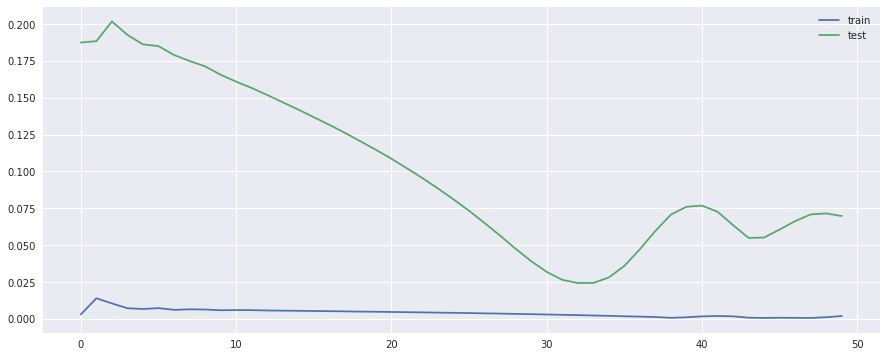

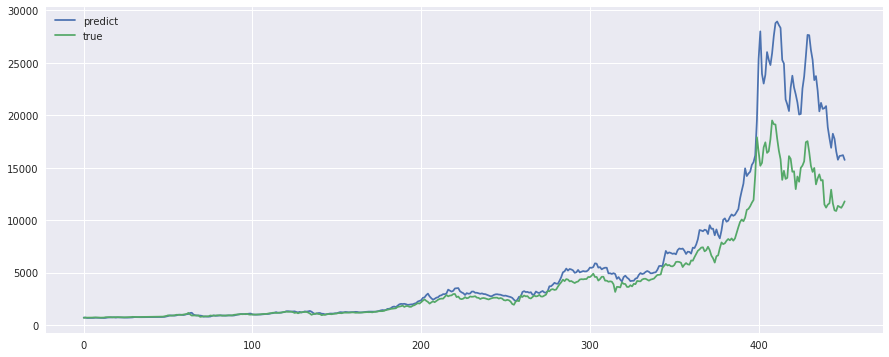

Test RMSE: 2915.452


In [36]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [11]:
                #---------------------#
				#Using additional data#
				#---------------------#

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

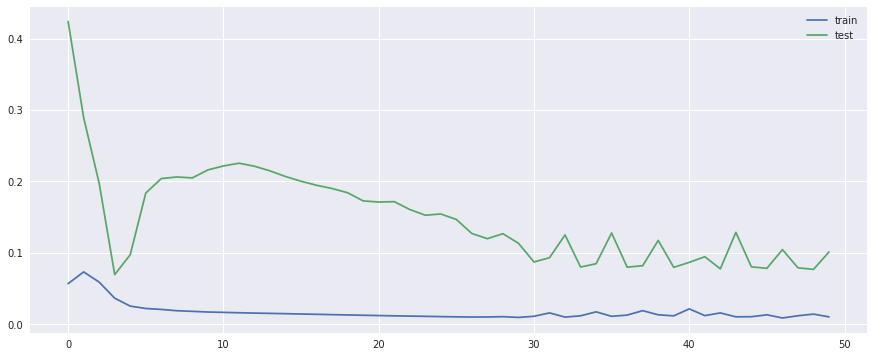

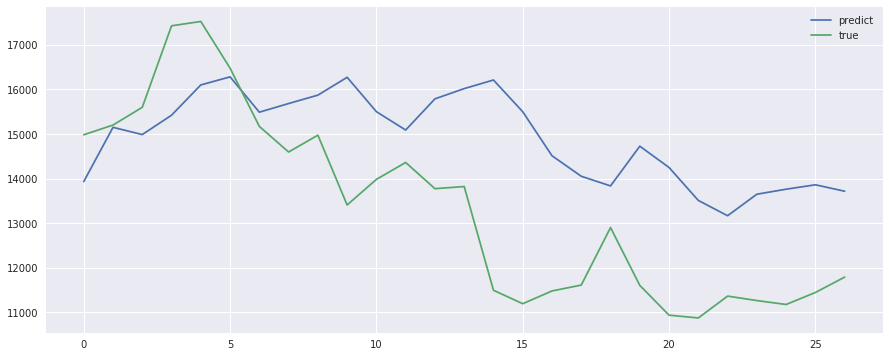

Test RMSE: 2273.501


In [55]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

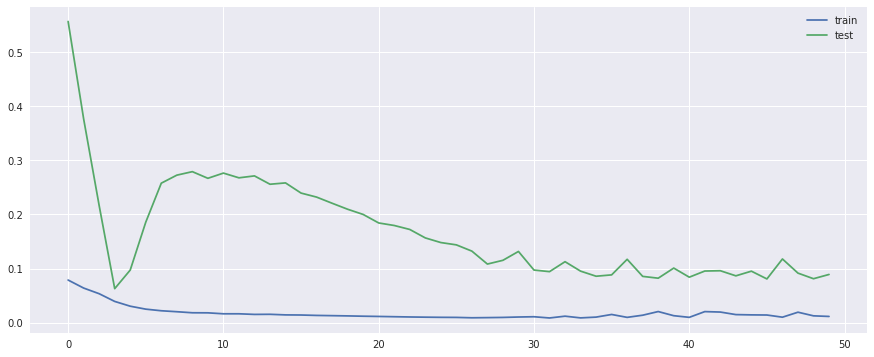

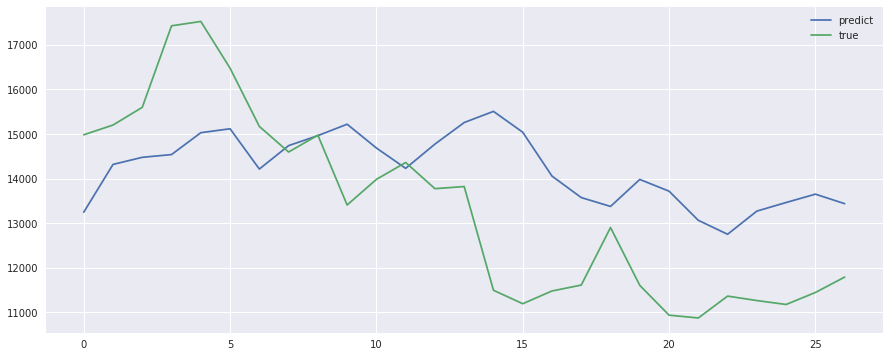

Test RMSE: 2000.534


In [56]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

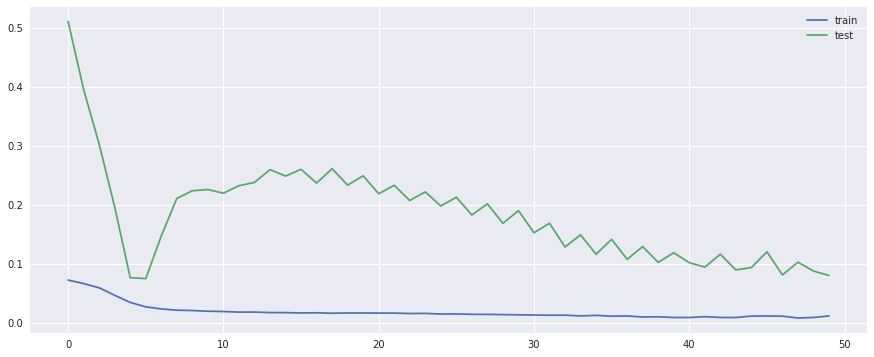

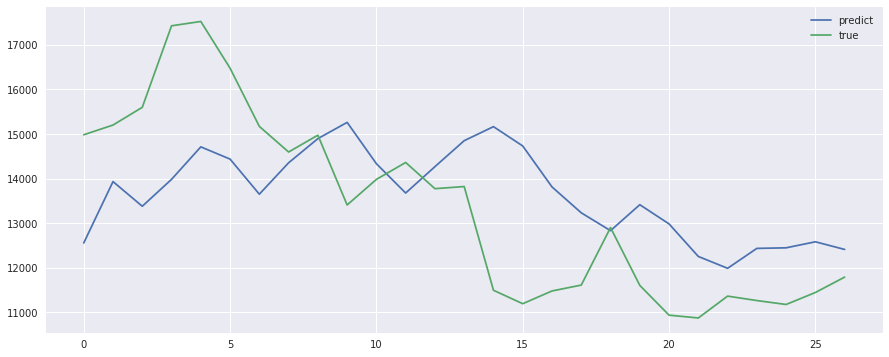

Test RMSE: 1853.489


In [57]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

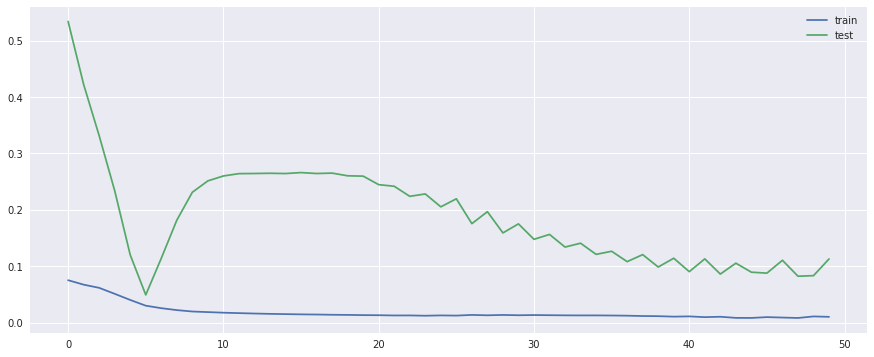

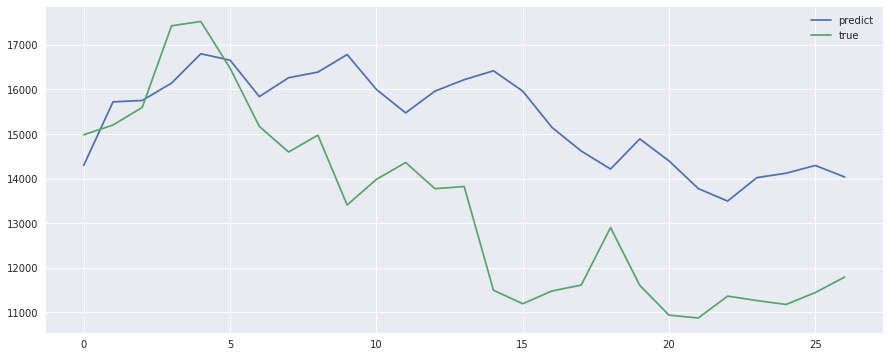

Test RMSE: 2525.181


In [58]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

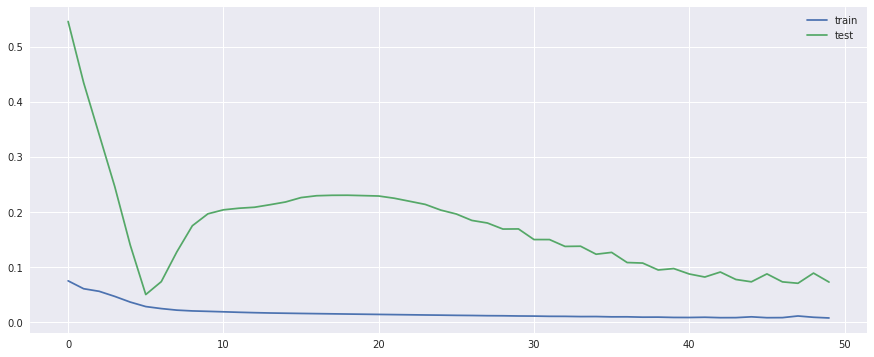

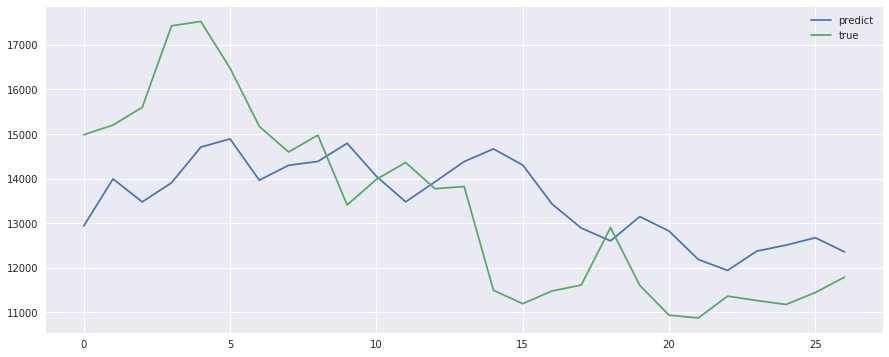

Test RMSE: 1679.948


In [59]:
#----------------------------#
#Using the last month to test#
#----------------------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= 878
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

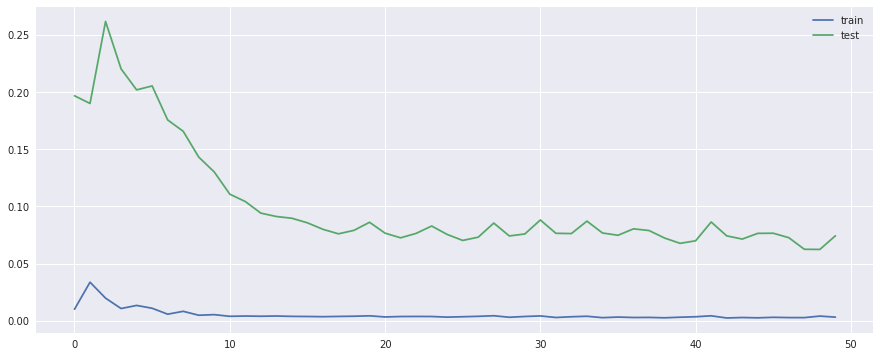

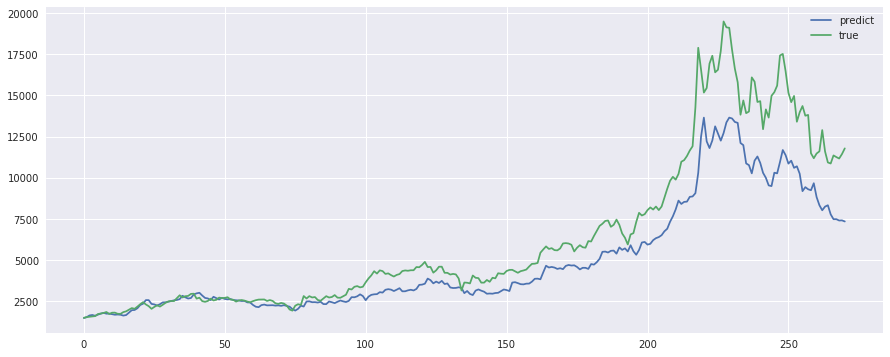

Test RMSE: 2130.380


In [61]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

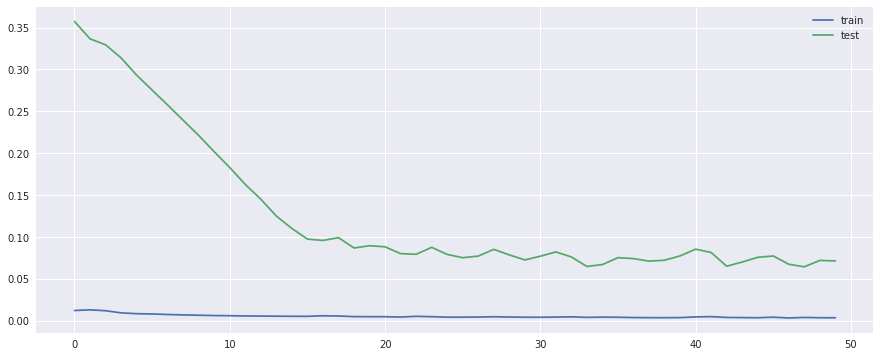

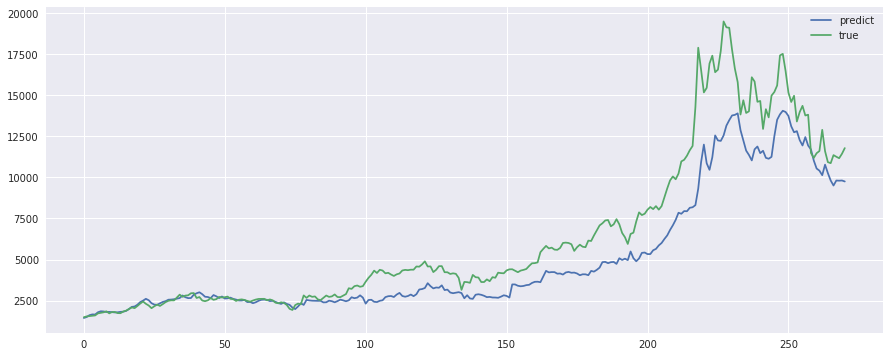

Test RMSE: 1973.148


In [62]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

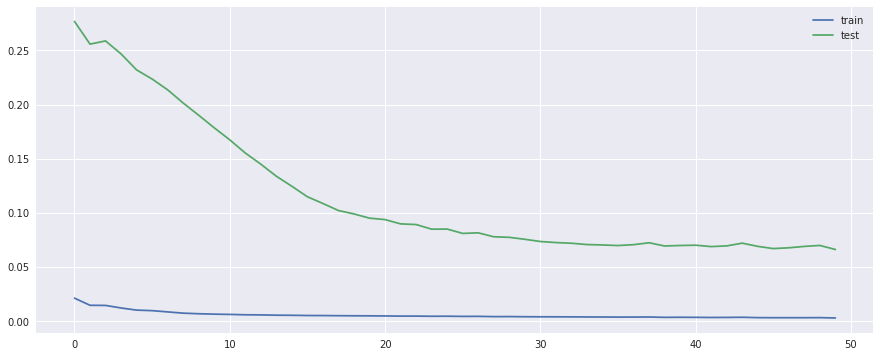

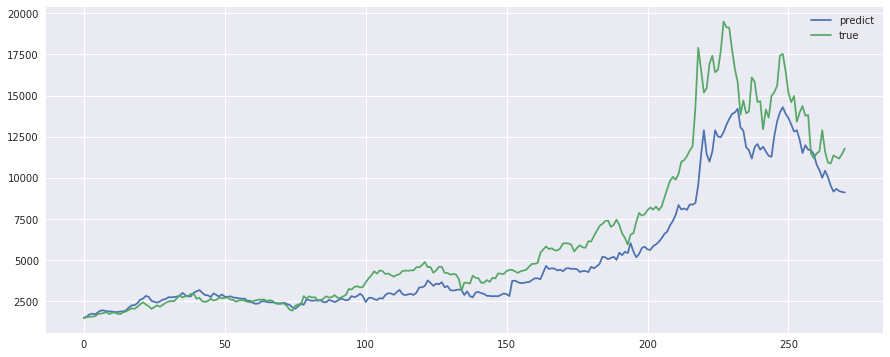

Test RMSE: 1841.695


In [63]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

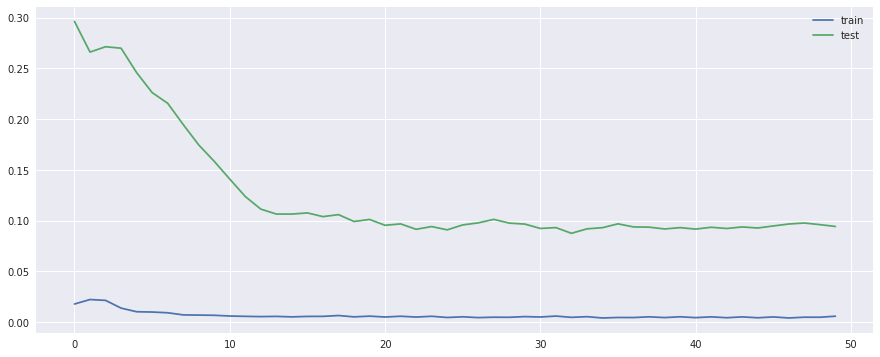

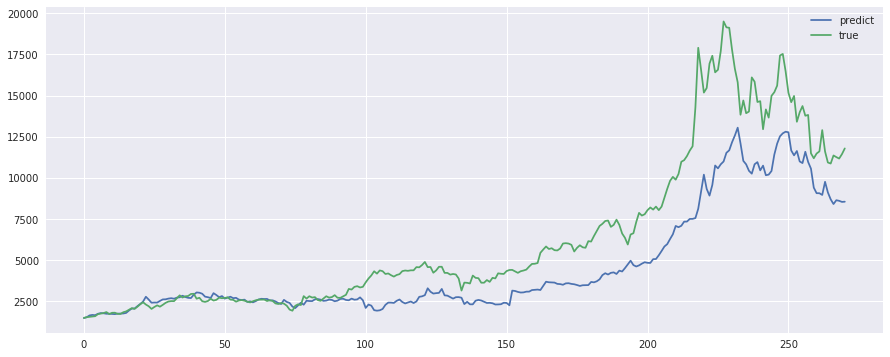

Test RMSE: 2557.536


In [64]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

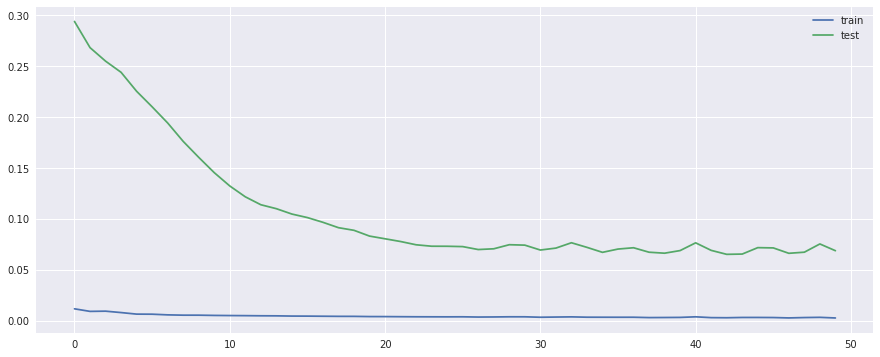

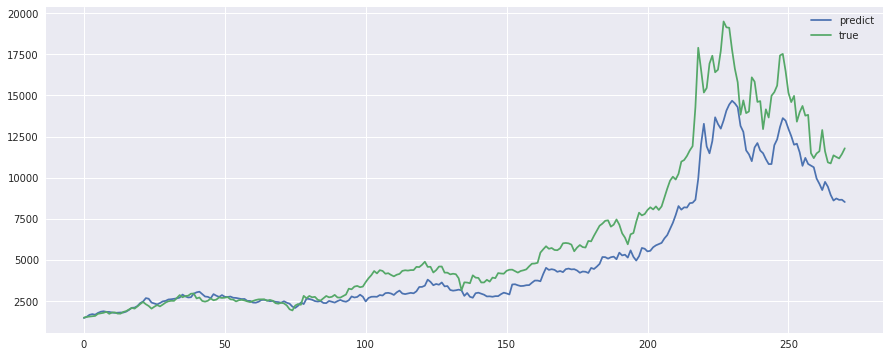

Test RMSE: 1867.756


In [65]:
#--------------#
#Train size 70%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

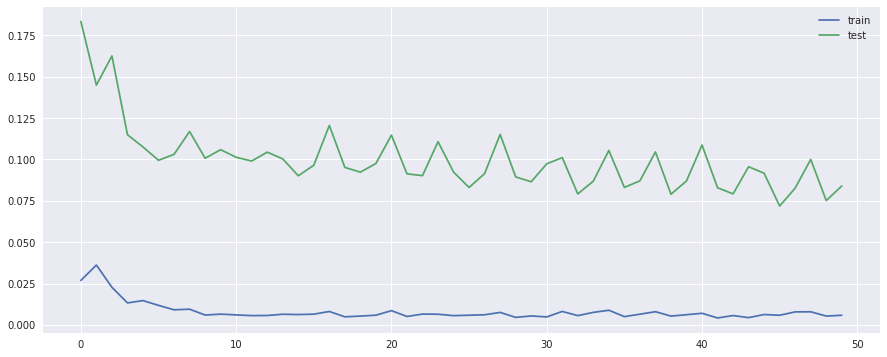

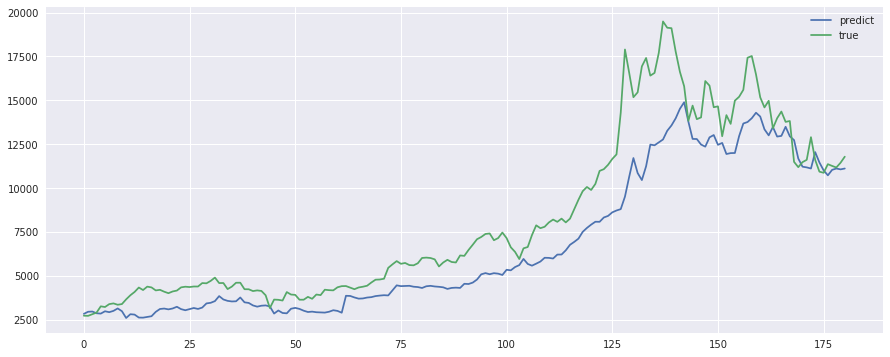

Test RMSE: 2121.630


In [66]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

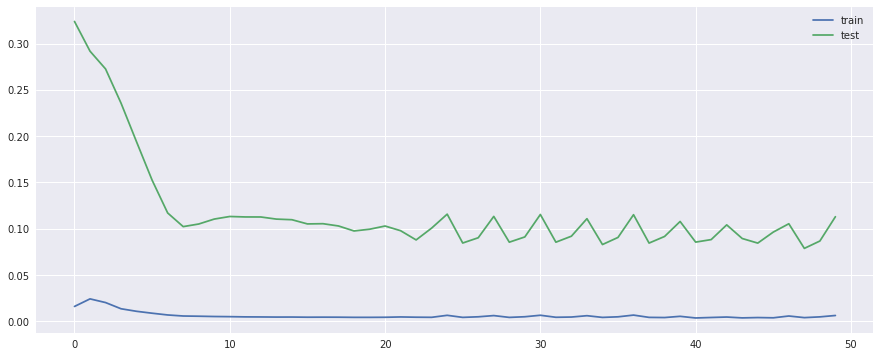

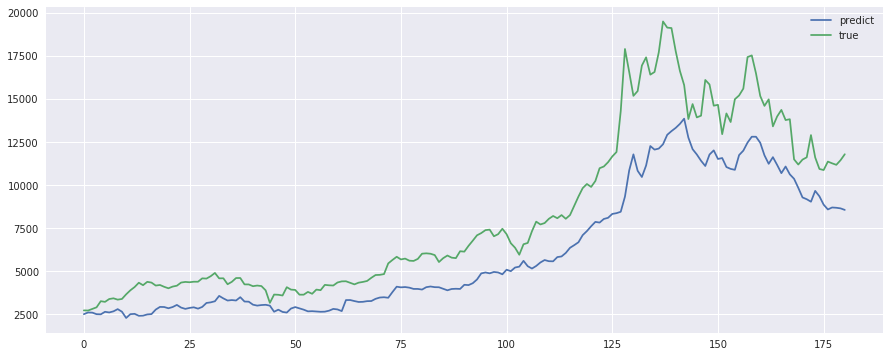

Test RMSE: 2584.384


In [67]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

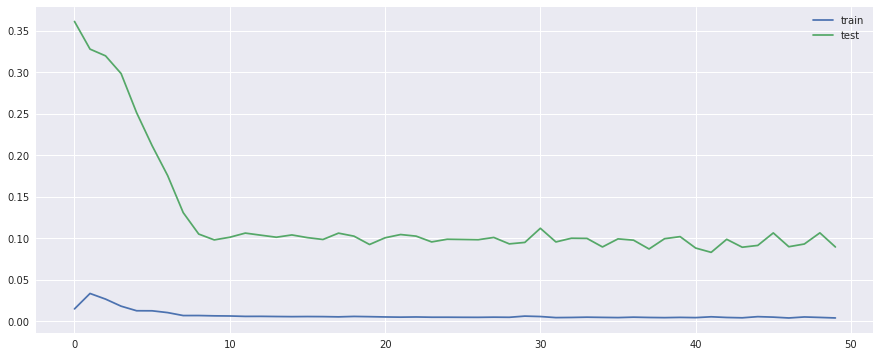

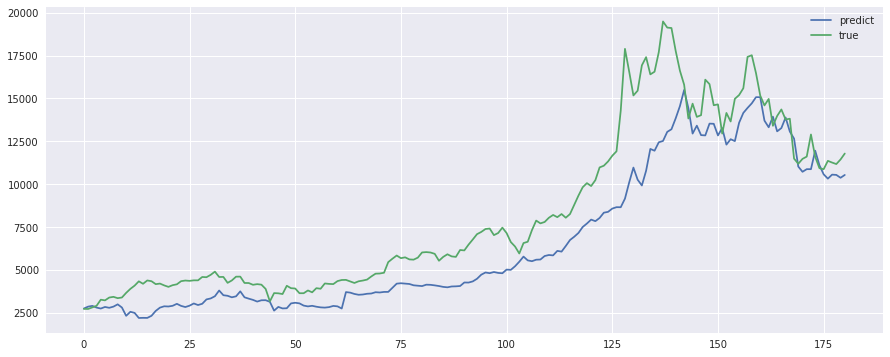

Test RMSE: 2234.045


In [68]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

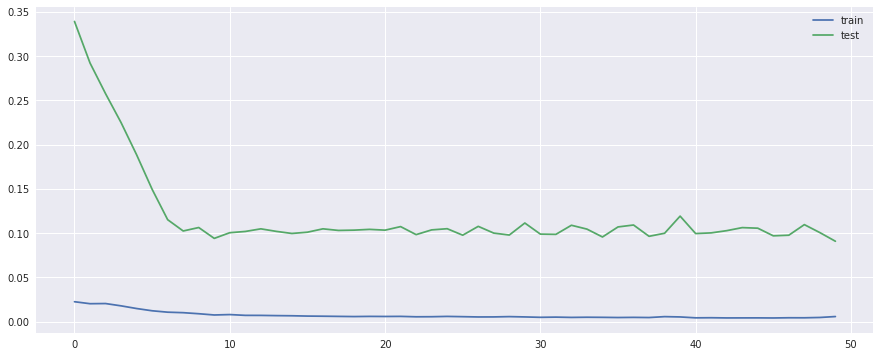

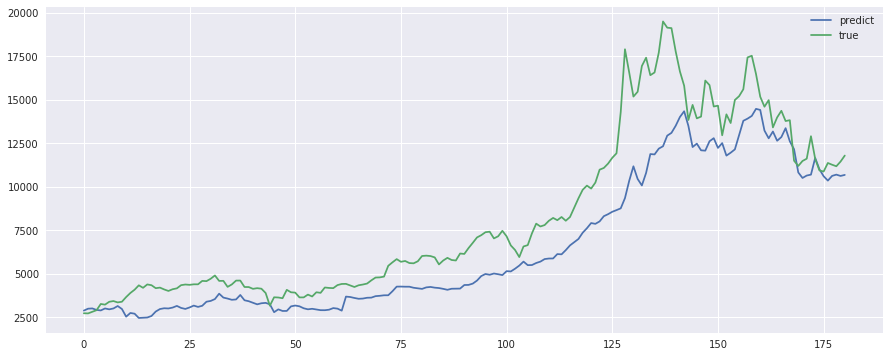

Test RMSE: 2266.516


In [69]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

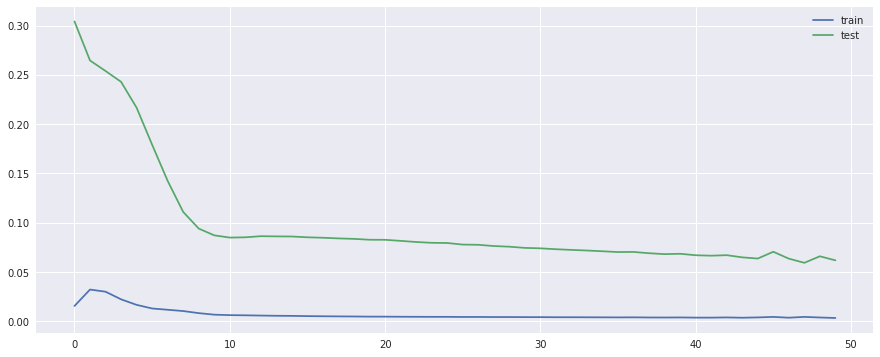

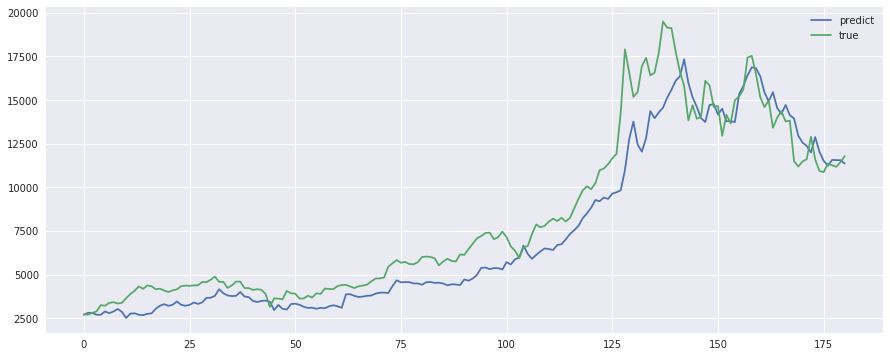

Test RMSE: 1546.087


In [70]:
#--------------#
#Train size 80%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

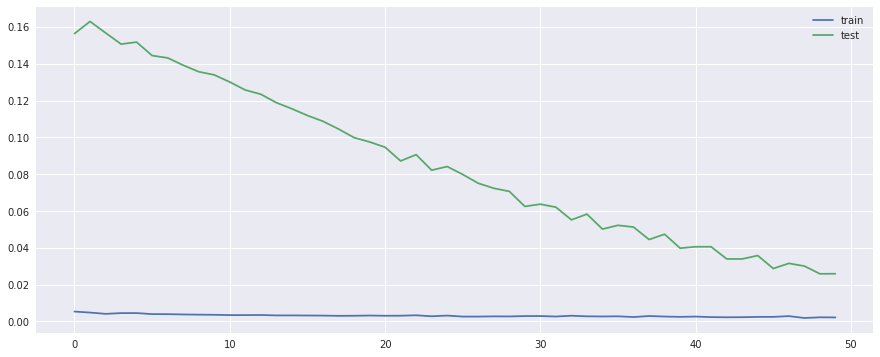

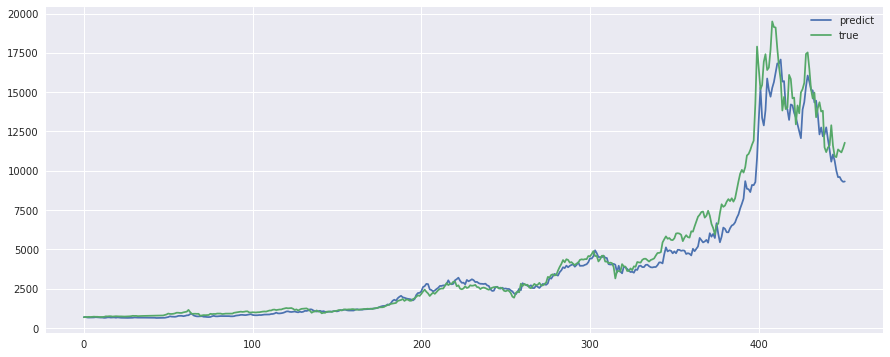

Test RMSE: 938.175


In [71]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

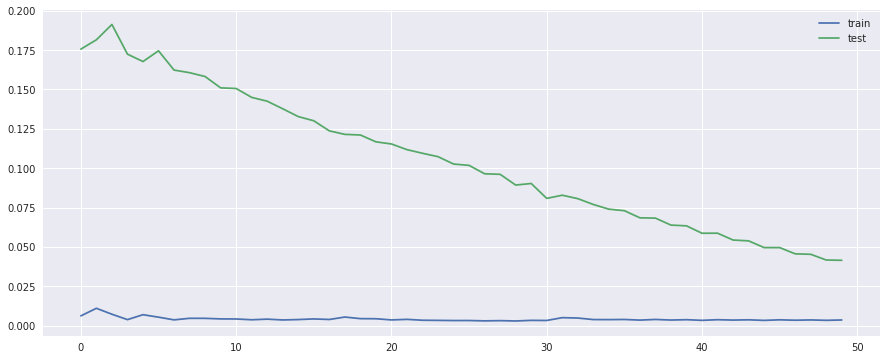

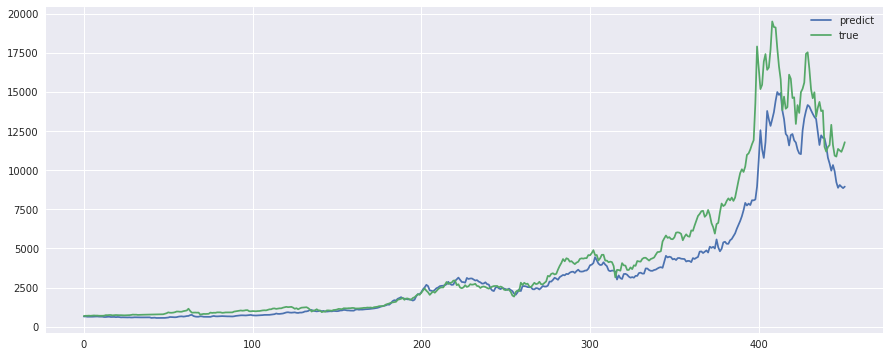

Test RMSE: 1421.392


In [72]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

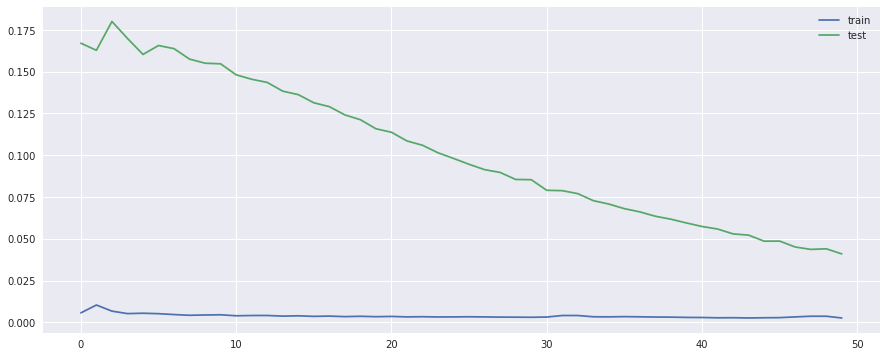

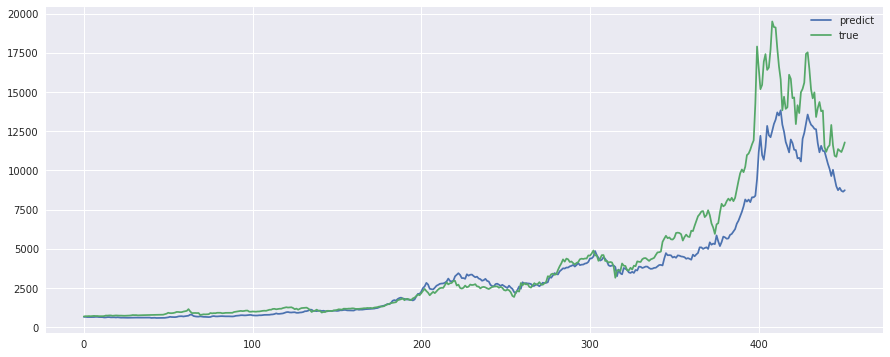

Test RMSE: 1478.105


In [73]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

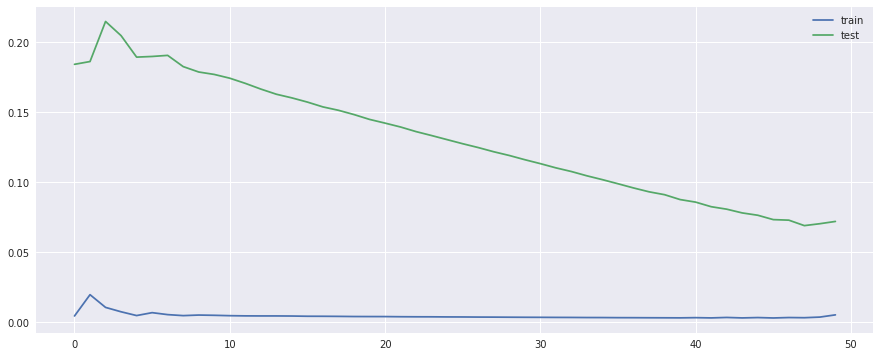

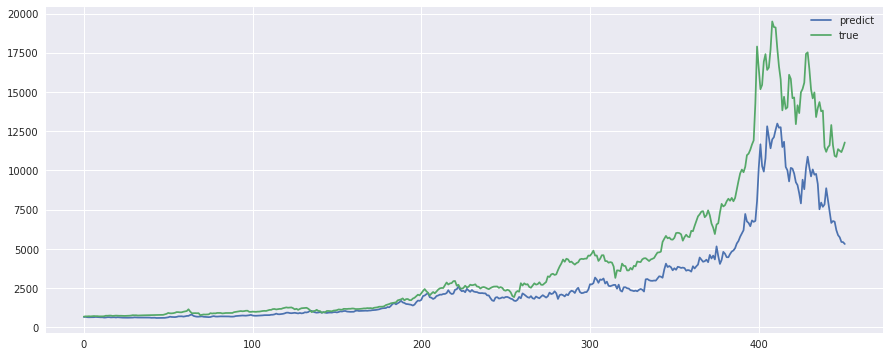

Test RMSE: 2280.470


In [74]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=90, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003582   0.001249   0.003033   0.523666   0.081311   0.001673   
2   0.002618   0.001923   0.003081   0.523666   0.081311   0.000228   
3   0.002830   0.000465   0.002250   0.523666   0.081311   0.000191   
4   0.002798   0.000347   0.002448   0.469572   0.129672   0.000196   
5   0.003105   0.000534   0.002401   0.422489   0.190164   0.000455   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.001203   0.000001   0.004442    0.022046    0.088294    0.001104   
2   0.001299   0.000001   0.003430    0.020124    0.080711    0.001090   
3   0.001398   0.000001   0.003570    0.020391    0.081764    0.001007   
4   0.001380   0.000001   0.003711    0.020658    0.082817    0.001142   
5   0.001333   0.000001   0.004301    0.021779    0.087241    0.001066   

   var13(t-1)  var14(t-1)  var15(t-1)    var16(t-1)  var17(t-1)   var1(t)  
1    0.000061    0.000775    0.000032  1.339390e-06 

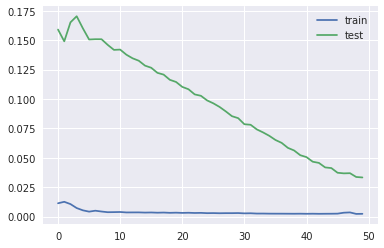

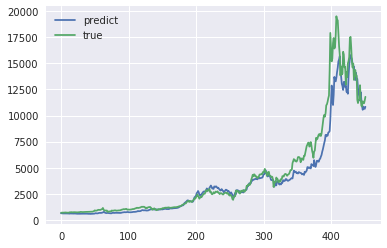

Test RMSE: 1213.394


In [11]:
#--------------#
#Train size 50%#
#--------------#

# load dataset
values = data.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train= int(len(data)*0.5)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)